In [1]:
# Summer 2022
!java -version

#Install Spark
#download file
!wget -q http://apache.osuosl.org/spark/spark-3.4.4/spark-3.4.4-bin-hadoop3.tgz
#extract the file
!tar xf spark-3.4.4-bin-hadoop3.tgz
#install findspark package
!pip install -q findspark

import os
os.environ["SPARK_HOME"] = "/content/spark-3.4.4-bin-hadoop3"

openjdk version "11.0.24" 2024-07-16
OpenJDK Runtime Environment (build 11.0.24+8-post-Ubuntu-1ubuntu322.04)
OpenJDK 64-Bit Server VM (build 11.0.24+8-post-Ubuntu-1ubuntu322.04, mixed mode, sharing)


In [2]:
import findspark
findspark.init()

In [3]:
# create entry points to spark
try:
    sc.stop()
except:
    pass
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
conf = SparkConf().setAppName("Lab4").setMaster("local[*]")#local[2]
sc=SparkContext(conf = conf)
spark = SparkSession(sparkContext=sc)

In [4]:
!ls

sample_data  spark-3.4.4-bin-hadoop3  spark-3.4.4-bin-hadoop3.tgz


In [11]:
!wget -O "Chicago_Traffic_Tracker_-_Congestion_Estimates_by_Segments.csv" https://data.cityofchicago.org/api/views/n4j6-wkkf/rows.csv?accessType=DOWNLOAD #Crashes
!wget -O "Traffic_Crashes_-_Crashes.csv"  https://data.cityofchicago.org/api/views/85ca-t3if/rows.csv?accessType=DOWNLOAD #Traffic

--2024-11-04 19:49:22--  https://data.cityofchicago.org/api/views/n4j6-wkkf/rows.csv?accessType=DOWNLOAD
Resolving data.cityofchicago.org (data.cityofchicago.org)... 100.28.82.57, 35.170.133.124, 174.129.43.10
Connecting to data.cityofchicago.org (data.cityofchicago.org)|100.28.82.57|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: ‘Chicago_Traffic_Tracker_-_Congestion_Estimates_by_Segments.csv’

Chicago_Traffic_Tra     [  <=>               ] 152.56K   401KB/s    in 0.4s    

2024-11-04 19:49:24 (401 KB/s) - ‘Chicago_Traffic_Tracker_-_Congestion_Estimates_by_Segments.csv’ saved [156225]

--2024-11-04 19:49:24--  https://data.cityofchicago.org/api/views/85ca-t3if/rows.csv?accessType=DOWNLOAD
Resolving data.cityofchicago.org (data.cityofchicago.org)... 100.28.82.57, 35.170.133.124, 174.129.43.10
Connecting to data.cityofchicago.org (data.cityofchicago.org)|100.28.82.57|:443... connected.
HTTP request sent, awaiting response... 20

In [6]:
#!wget -O "Chicago_Traffic_Tracker_-_Historical_Congestion_Estimates_by_Segment.csv" https://data.cityofchicago.org/api/views/sxs8-h27x/rows.csv?accessType=DOWNLOAD #Congestion

In [13]:
#Read in Files
dfTraffic = spark.read.option('header','true').csv('Chicago_Traffic_Tracker_-_Congestion_Estimates_by_Segments.csv',inferSchema = True)
dfCrashes = spark.read.option('header','true').csv('Traffic_Crashes_-_Crashes.csv',inferSchema = True)

*#Questions*


1.   
a. What time of day do the most crashes occur?
b. What day of the week has the most crashes?
c. What month has the most crashes?
2.
a. What first crash type causes the most injuries?
b. What first crash type causes the most fatalities?
3. What is the rarest and most common first crash types?
4.   What beat is most likely to have a hit and run?
5.   Do all street directions have equivalent probability of a crash?
6. Is there a relationship between the beat a crash occurred in and the number of null values/unable to determine in its record?
7.
a. What is the most common primary cause of crashes and on average how much damage is caused by it?
b. What primary cause causes the most fatalities
8. What are the most dangerous streets in:
a. number of crashes
b. number of total injuries
c. number of fatalities
e. Are they close to each other?
9. Do higher speed limits always result in worse outcomes? Is there an inflection point in speed limits past which theres a significant increase in crashes, injuries, etc.?
a. More crashes
b. More fatalities
c. More injuries
d. More damages


In [8]:
import pyspark.sql.functions as F
import matplotlib.pyplot as pltra
import pandas as pd
import seaborn as sns

In [14]:
dfCrashes.show()

+--------------------+----------------+--------------------+------------------+----------------------+--------------------+-----------------+--------------------+--------------------+--------------------+--------+------------------+--------------------+-----------+--------------------+--------------------+----------------------+------------------+-------------+-------------+--------------------+-----------------------+----------------------+---------+----------------+-----------------+------------------+--------------+------------------+---------+-----------+--------------+-----------------+---------+--------------------+--------------+--------------+-----------------------+---------------------------+-----------------------------+----------------------+----------------+----------+-----------------+-----------+------------+-------------+--------------------+
|     CRASH_RECORD_ID|CRASH_DATE_EST_I|          CRASH_DATE|POSTED_SPEED_LIMIT|TRAFFIC_CONTROL_DEVICE|    DEVICE_CONDITION|WEATHE

In [15]:
dfTraffic.show()

+---------+-------------------+---------+--------------------+----------------+--------------+---------------+-------------------+---------------+---------------+--------------+-------------+--------------+-------------------+
|SEGMENTID|             STREET|DIRECTION|         FROM_STREET|       TO_STREET|        LENGTH| STREET_HEADING|           COMMENTS|START_LONGITUDE| START_LATITUDE| END_LONGITUDE| END_LATITUDE| CURRENT_SPEED|       LAST_UPDATED|
+---------+-------------------+---------+--------------------+----------------+--------------+---------------+-------------------+---------------+---------------+--------------+-------------+--------------+-------------------+
|     1284|            Chicago|       WB|       Lake Shore Dr|        Michigan|          0.37|              E|               null|     -87.617048|      41.896936|    -87.624241|    41.896835|            -1|2011-08-10 00:00:00|
|      951|         Washington|       WB|              Kedzie|       Schraeder|          0.2

In [23]:
dfCrashes.count()

889546

In [19]:
from pyspark.sql.functions import col, sum

dfCrashes.select([sum(col(column).isNull().cast("int")).alias(column) for column in dfCrashes.columns]).show()


+---------------+----------------+----------+------------------+----------------------+----------------+-----------------+------------------+----------------+---------------+--------+---------+--------------------+-----------+-----------+----------+----------------------+------------------+-------------+------+--------------------+-----------------------+----------------------+---------+----------------+-----------+------------------+--------------+------------------+---------+-----------+--------------+-----------------+---------+------------------+--------------+--------------+-----------------------+---------------------------+-----------------------------+----------------------+----------------+----------+-----------------+-----------+--------+---------+--------+
|CRASH_RECORD_ID|CRASH_DATE_EST_I|CRASH_DATE|POSTED_SPEED_LIMIT|TRAFFIC_CONTROL_DEVICE|DEVICE_CONDITION|WEATHER_CONDITION|LIGHTING_CONDITION|FIRST_CRASH_TYPE|TRAFFICWAY_TYPE|LANE_CNT|ALIGNMENT|ROADWAY_SURFACE_COND|ROAD_DEF

In [ ]:
dfCrashes.dtypes

[('CRASH_RECORD_ID', 'string'),
 ('RD_NO', 'string'),
 ('CRASH_DATE_EST_I', 'string'),
 ('CRASH_DATE', 'string'),
 ('POSTED_SPEED_LIMIT', 'int'),
 ('TRAFFIC_CONTROL_DEVICE', 'string'),
 ('DEVICE_CONDITION', 'string'),
 ('WEATHER_CONDITION', 'string'),
 ('LIGHTING_CONDITION', 'string'),
 ('FIRST_CRASH_TYPE', 'string'),
 ('TRAFFICWAY_TYPE', 'string'),
 ('LANE_CNT', 'int'),
 ('ALIGNMENT', 'string'),
 ('ROADWAY_SURFACE_COND', 'string'),
 ('ROAD_DEFECT', 'string'),
 ('REPORT_TYPE', 'string'),
 ('CRASH_TYPE', 'string'),
 ('INTERSECTION_RELATED_I', 'string'),
 ('NOT_RIGHT_OF_WAY_I', 'string'),
 ('HIT_AND_RUN_I', 'string'),
 ('DAMAGE', 'string'),
 ('DATE_POLICE_NOTIFIED', 'string'),
 ('PRIM_CONTRIBUTORY_CAUSE', 'string'),
 ('SEC_CONTRIBUTORY_CAUSE', 'string'),
 ('STREET_NO', 'int'),
 ('STREET_DIRECTION', 'string'),
 ('STREET_NAME', 'string'),
 ('BEAT_OF_OCCURRENCE', 'int'),
 ('PHOTOS_TAKEN_I', 'string'),
 ('STATEMENTS_TAKEN_I', 'string'),
 ('DOORING_I', 'string'),
 ('WORK_ZONE_I', 'string'),
 

+----------+-----+
|CRASH_HOUR|count|
+----------+-----+
|        15|55692|
|        16|55265|
|        17|53938|
|        14|48658|
|        18|44576|
|        13|44217|
|        12|42719|
|         8|38162|
|        11|36895|
|         9|33305|
|        10|32938|
|        19|32823|
|         7|30542|
|        20|26515|
|        21|23682|
|        22|21679|
|        23|18808|
|         6|15754|
|         0|15577|
|         1|13276|
+----------+-----+
only showing top 20 rows

+-----------------+------+
|CRASH_DAY_OF_WEEK| count|
+-----------------+------+
|                6|117939|
|                7|107309|
|                5|104044|
|                3|103078|
|                4|102535|
|                2| 99721|
|                1| 89480|
+-----------------+------+

+-----------+-----+
|CRASH_MONTH|count|
+-----------+-----+
|         10|66700|
|          9|62798|
|          5|62579|
|         12|61713|
|          8|61122|
|         11|60486|
|          7|59436|
|          3|58876|


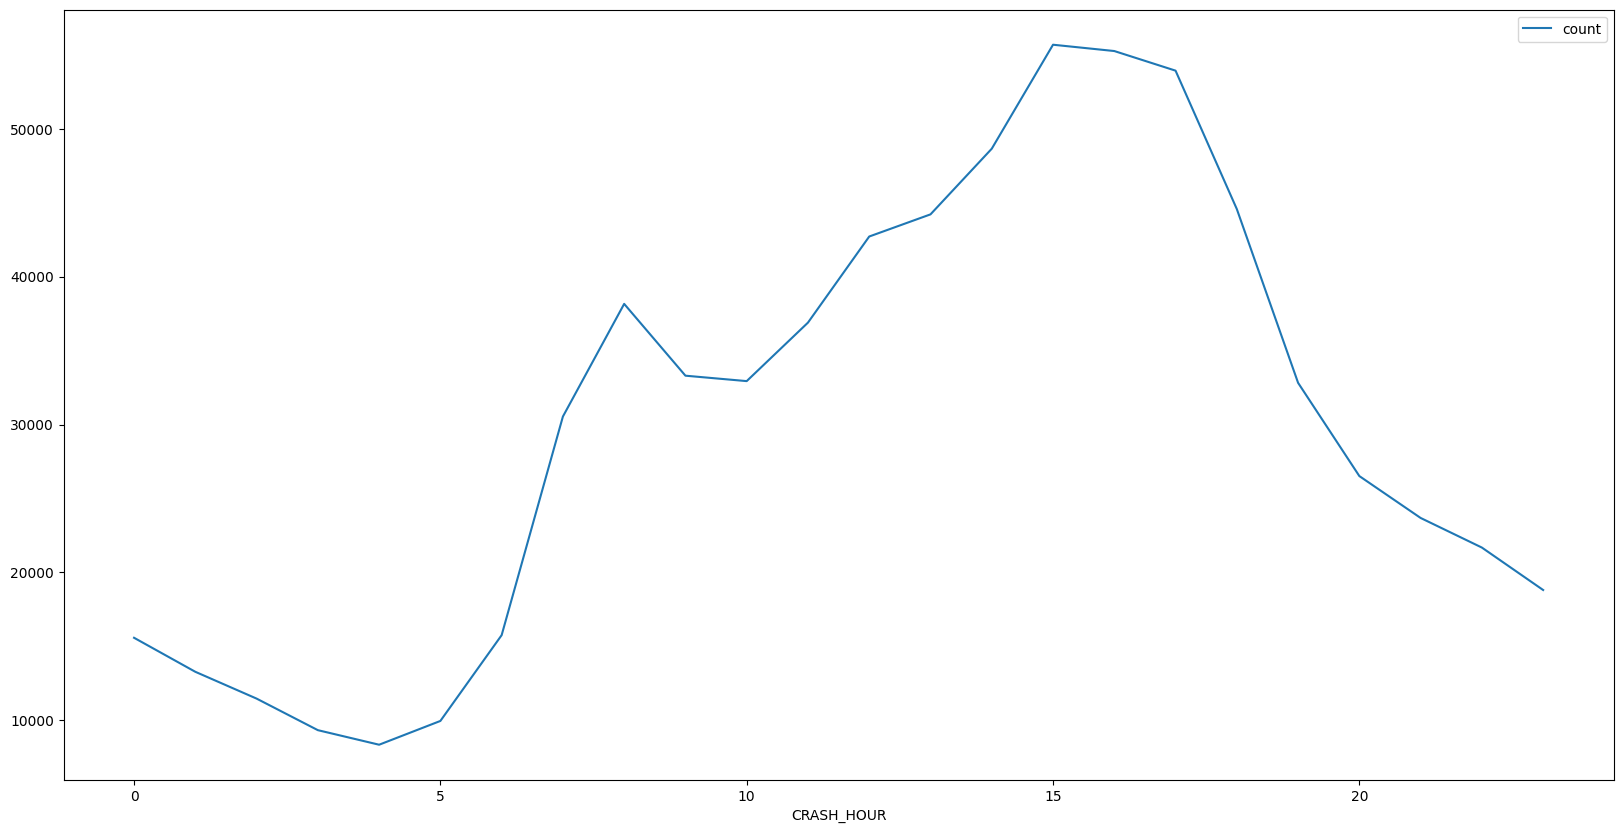

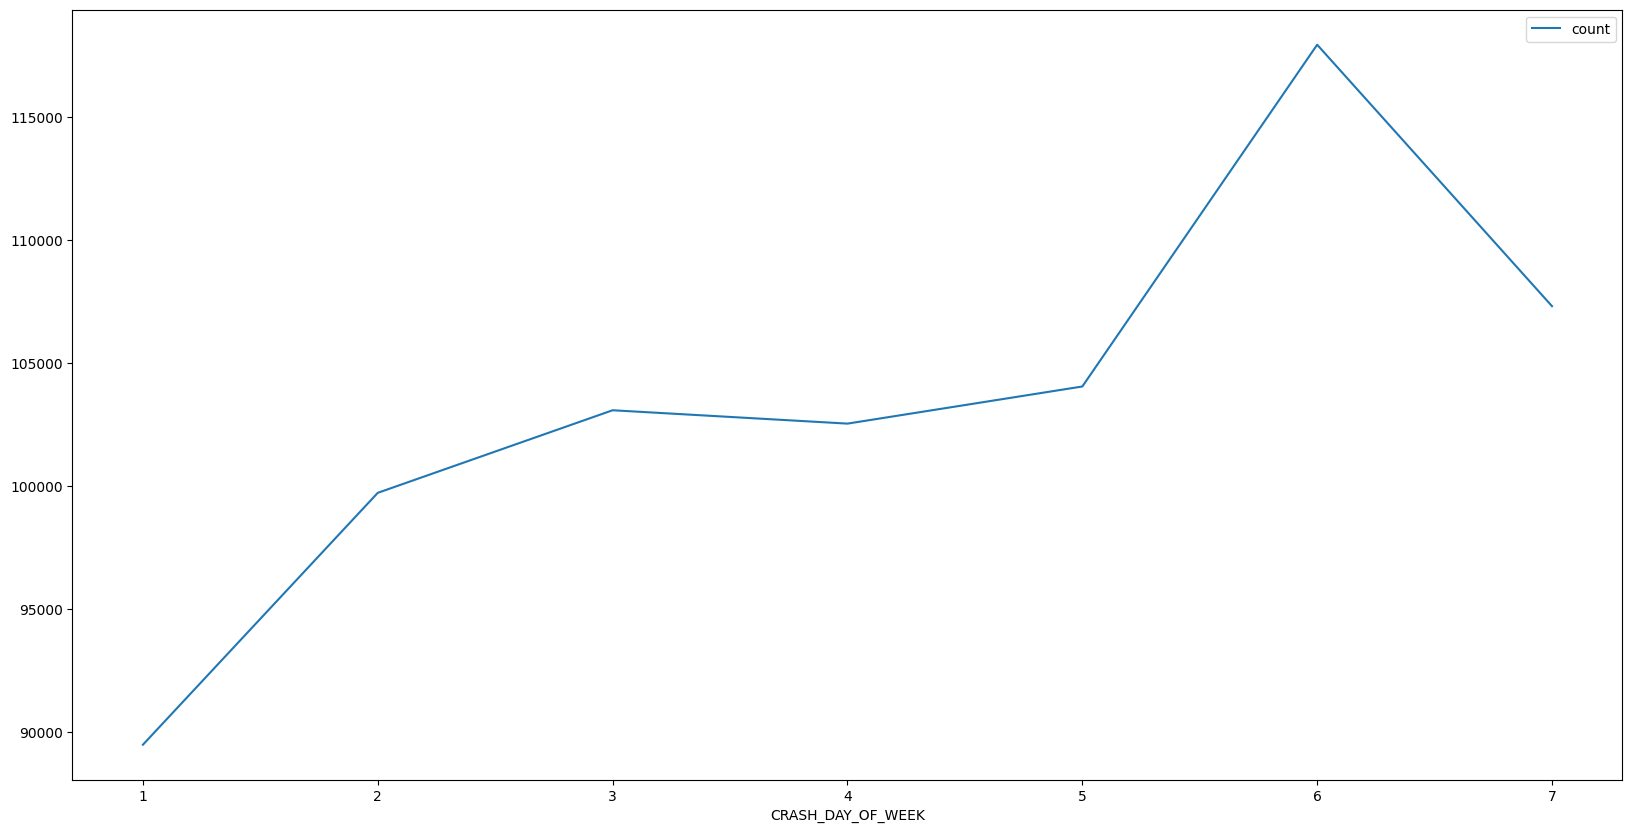

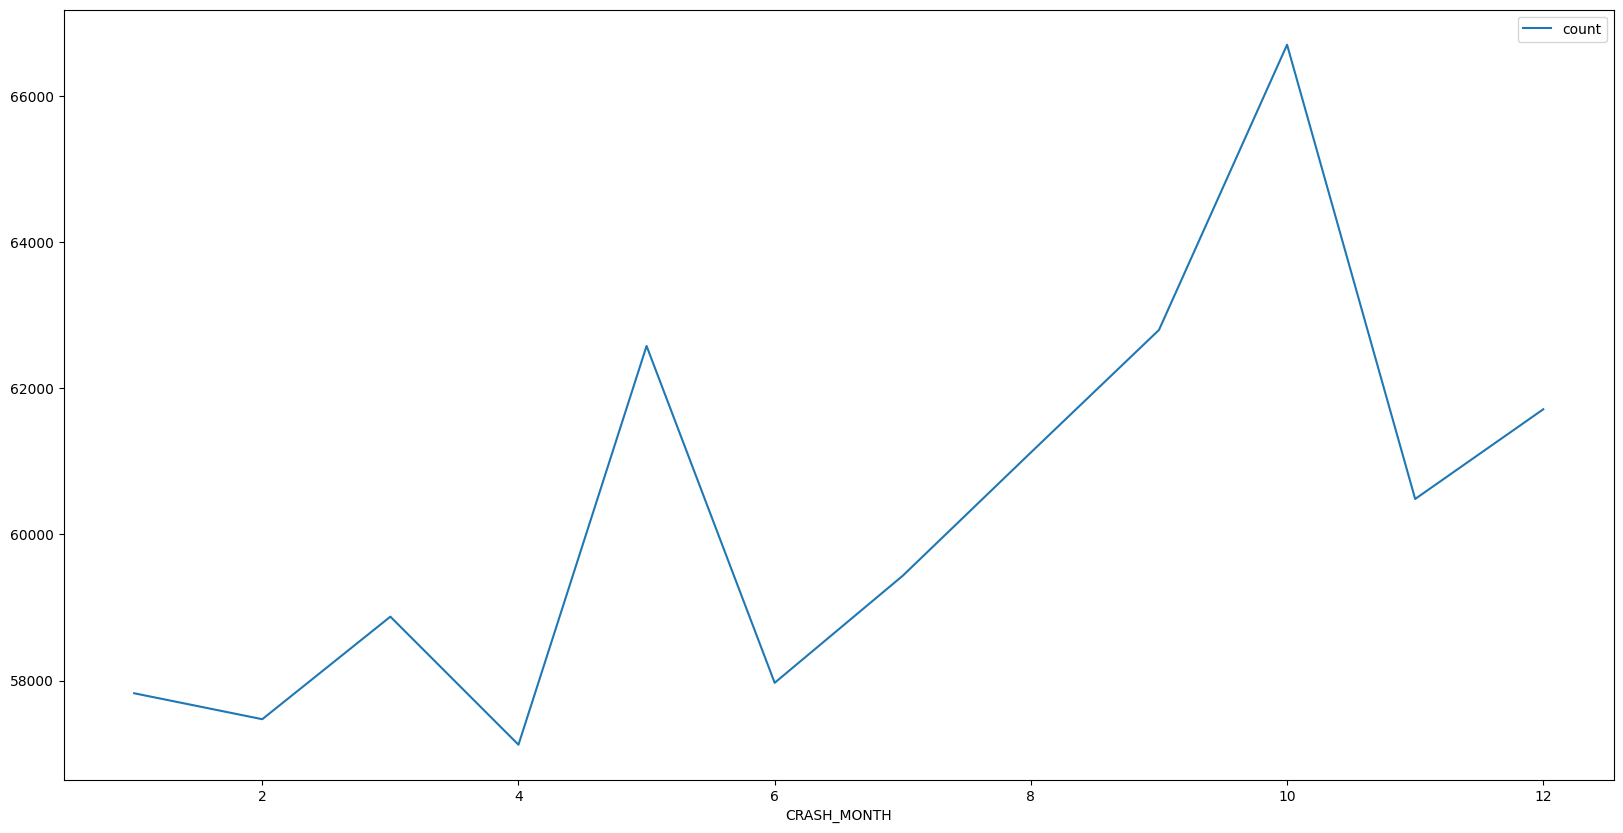

In [ ]:
#Question #1


#What time of day do the most crashes occur?

dfq1a = dfCrashes.groupby(dfCrashes['CRASH_HOUR']).count().orderBy(F.col('count').desc())
dfq1a.show()
#What day of the week has the most crashes?

dfq1b = dfCrashes.groupby(dfCrashes['CRASH_DAY_OF_WEEK']).count().orderBy(F.col('count').desc())
dfq1b.show()

#What month has the most crashes?
dfq1c = dfCrashes.groupby(dfCrashes['CRASH_MONTH']).count().orderBy(F.col('count').desc())
dfq1c.show()



#Graphs
if(dfq1a.count()<1000 and dfq1b.count() < 1000 and dfq1c.count() < 1000):
  pd = dfq1a.orderBy(F.col('CRASH_HOUR').asc()).toPandas()
  pd.plot.line(x='CRASH_HOUR', y='count',figsize=(20, 10))
  pd = dfq1b.orderBy(F.col('CRASH_DAY_OF_WEEK').asc()).toPandas()
  pd.plot.line(x='CRASH_DAY_OF_WEEK', y='count',figsize=(20, 10))
  pd = dfq1c.orderBy(F.col('CRASH_MONTH').asc()).toPandas()
  pd.plot.line(x='CRASH_MONTH', y='count',figsize=(20, 10))



+----------------------------+-------------------+
|FIRST_CRASH_TYPE            |sum(INJURIES_TOTAL)|
+----------------------------+-------------------+
|REAR END                    |29879              |
|ANGLE                       |27607              |
|TURNING                     |24445              |
|PEDESTRIAN                  |15412              |
|SIDESWIPE SAME DIRECTION    |7689               |
|FIXED OBJECT                |7579               |
|PEDALCYCLIST                |7434               |
|PARKED MOTOR VEHICLE        |7030               |
|HEAD ON                     |3391               |
|SIDESWIPE OPPOSITE DIRECTION|1597               |
|OTHER OBJECT                |998                |
|OTHER NONCOLLISION          |393                |
|REAR TO SIDE                |380                |
|REAR TO FRONT               |374                |
|OVERTURNED                  |252                |
|ANIMAL                      |35                 |
|REAR TO REAR                |2

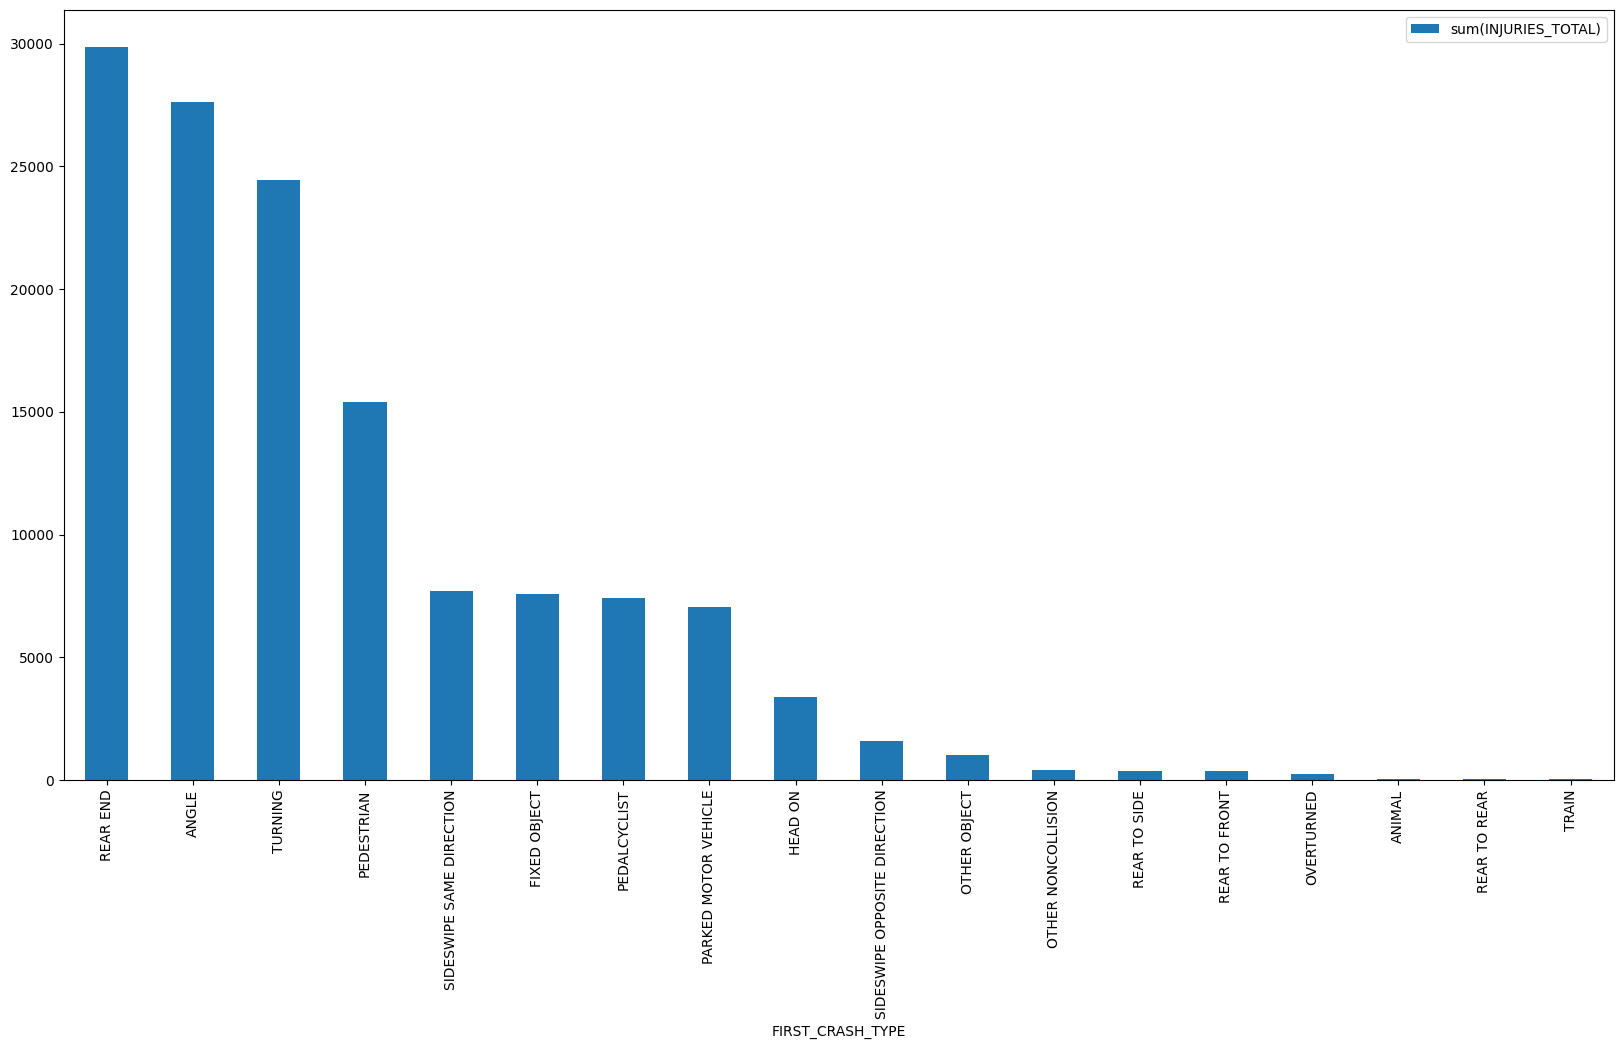

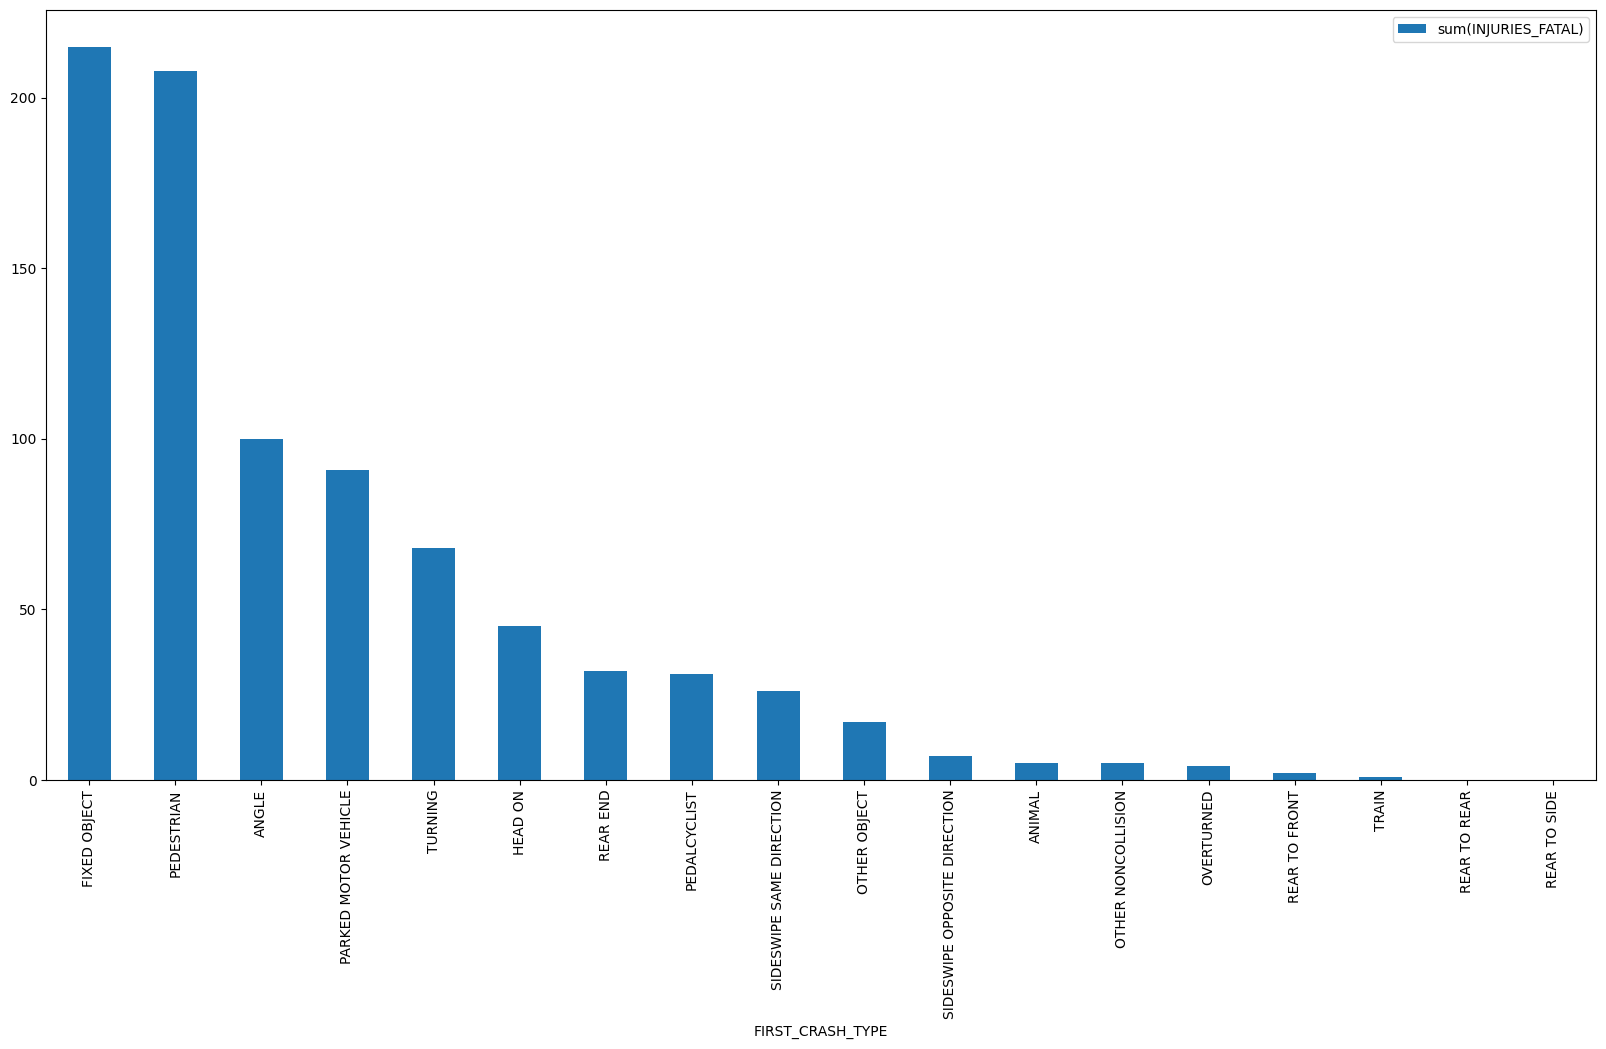

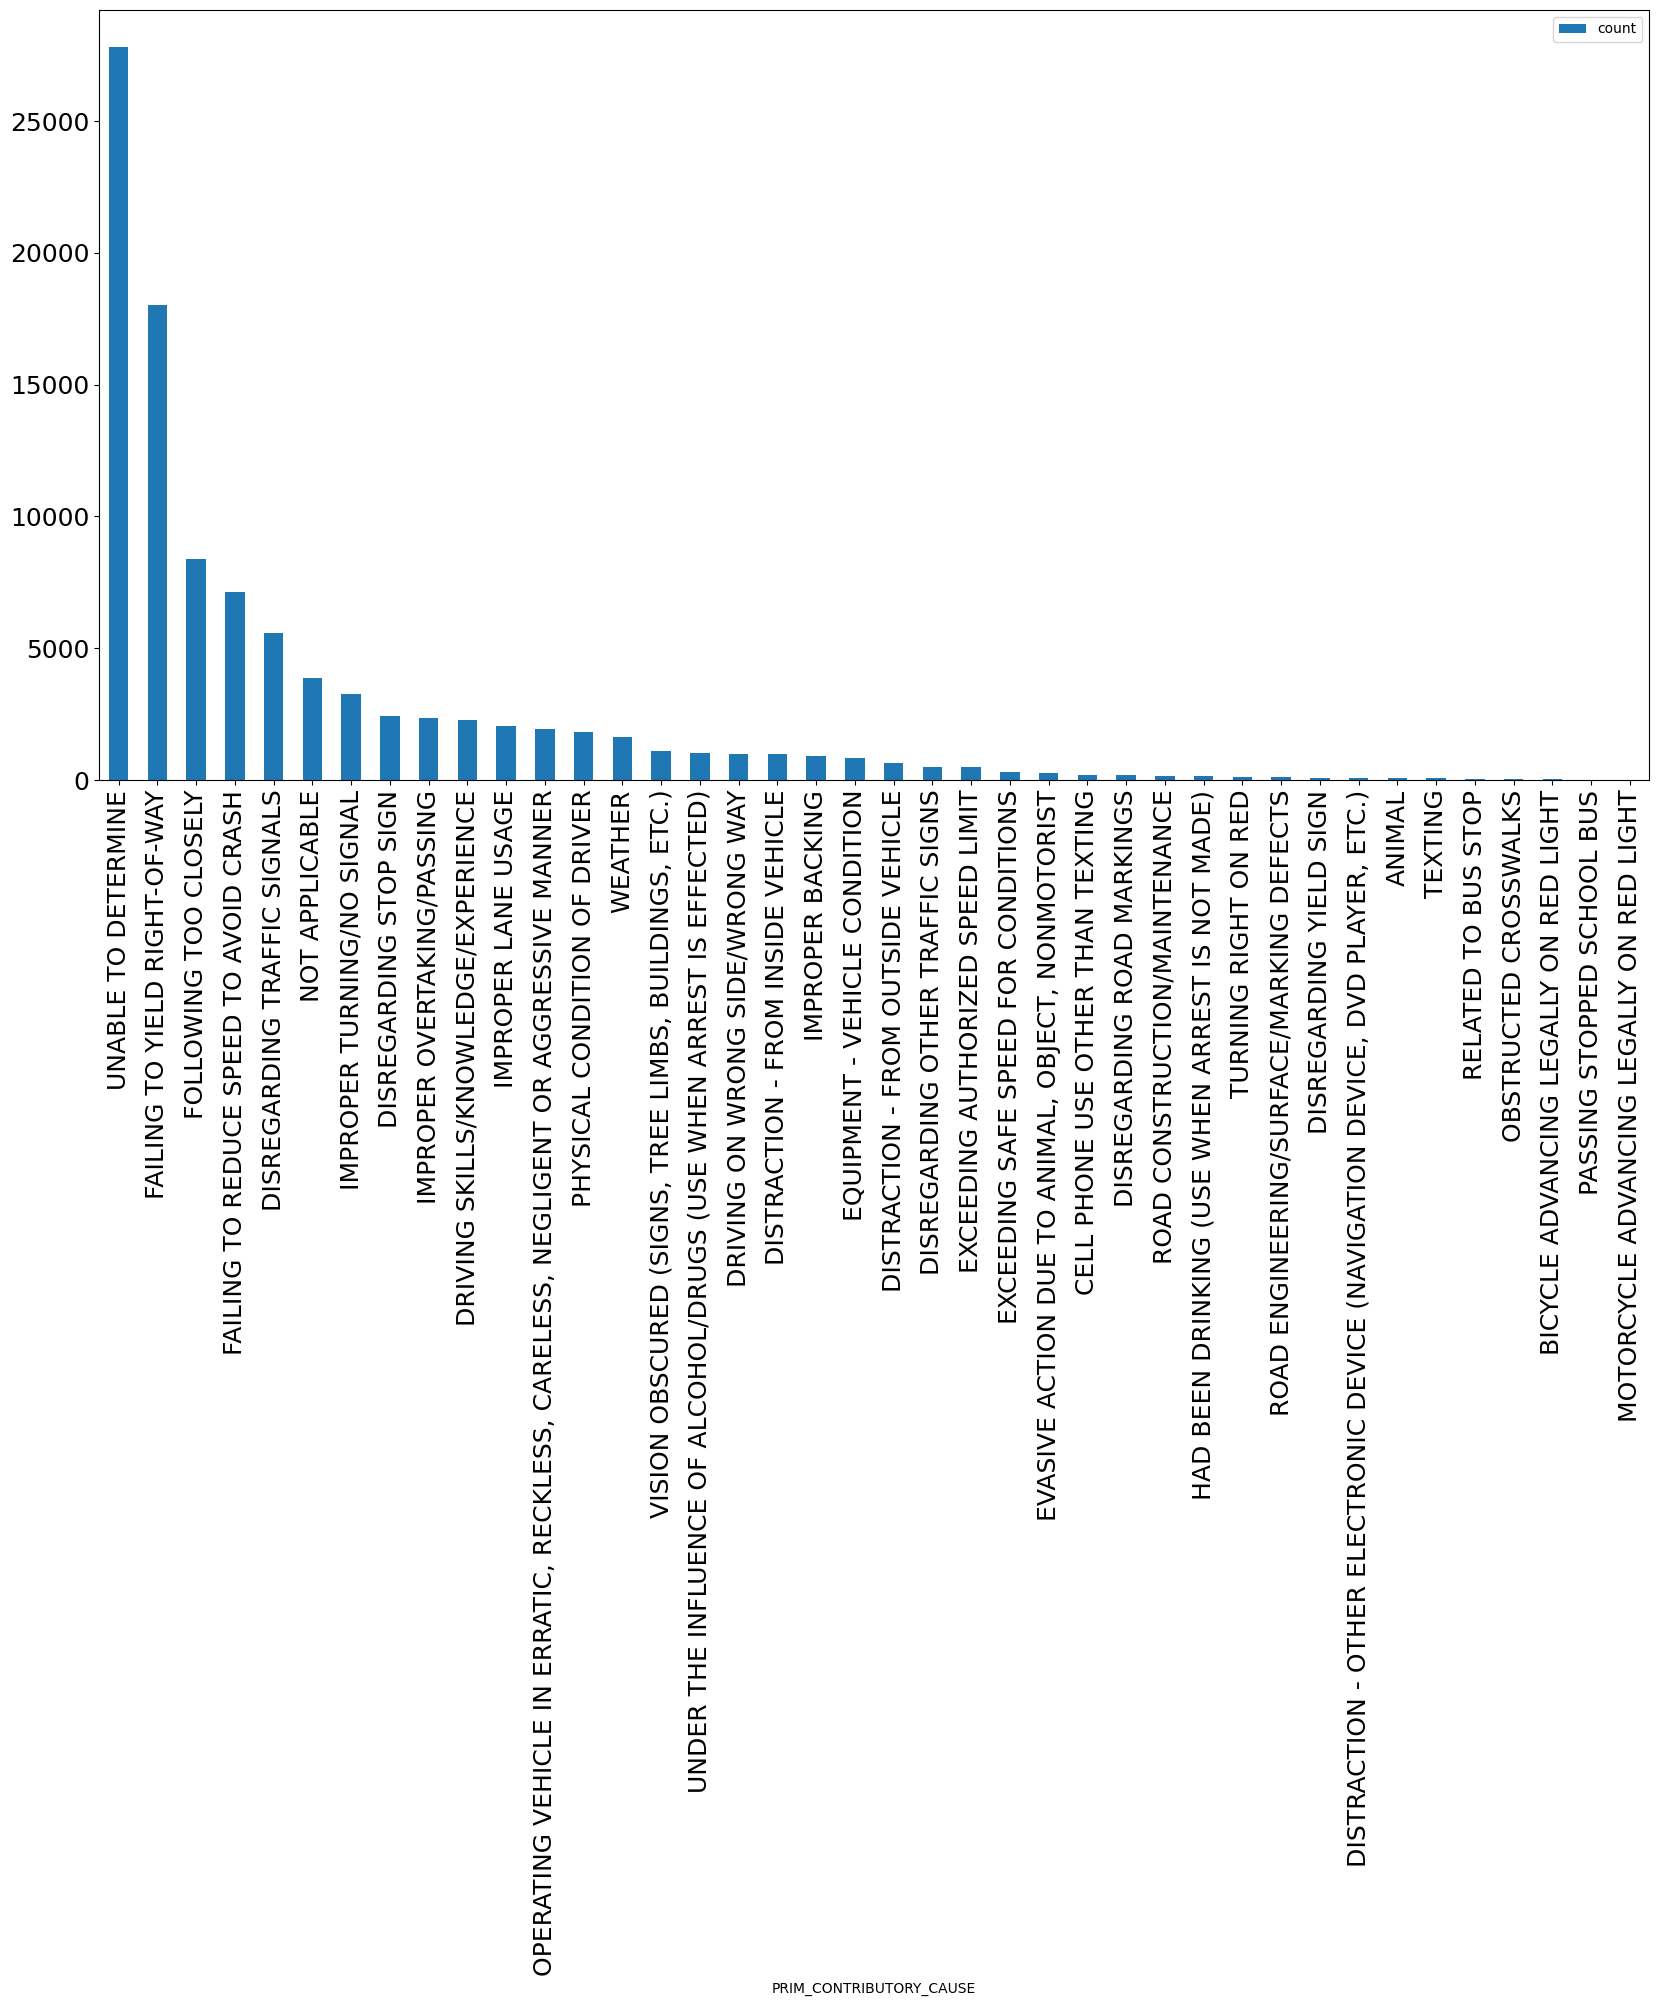

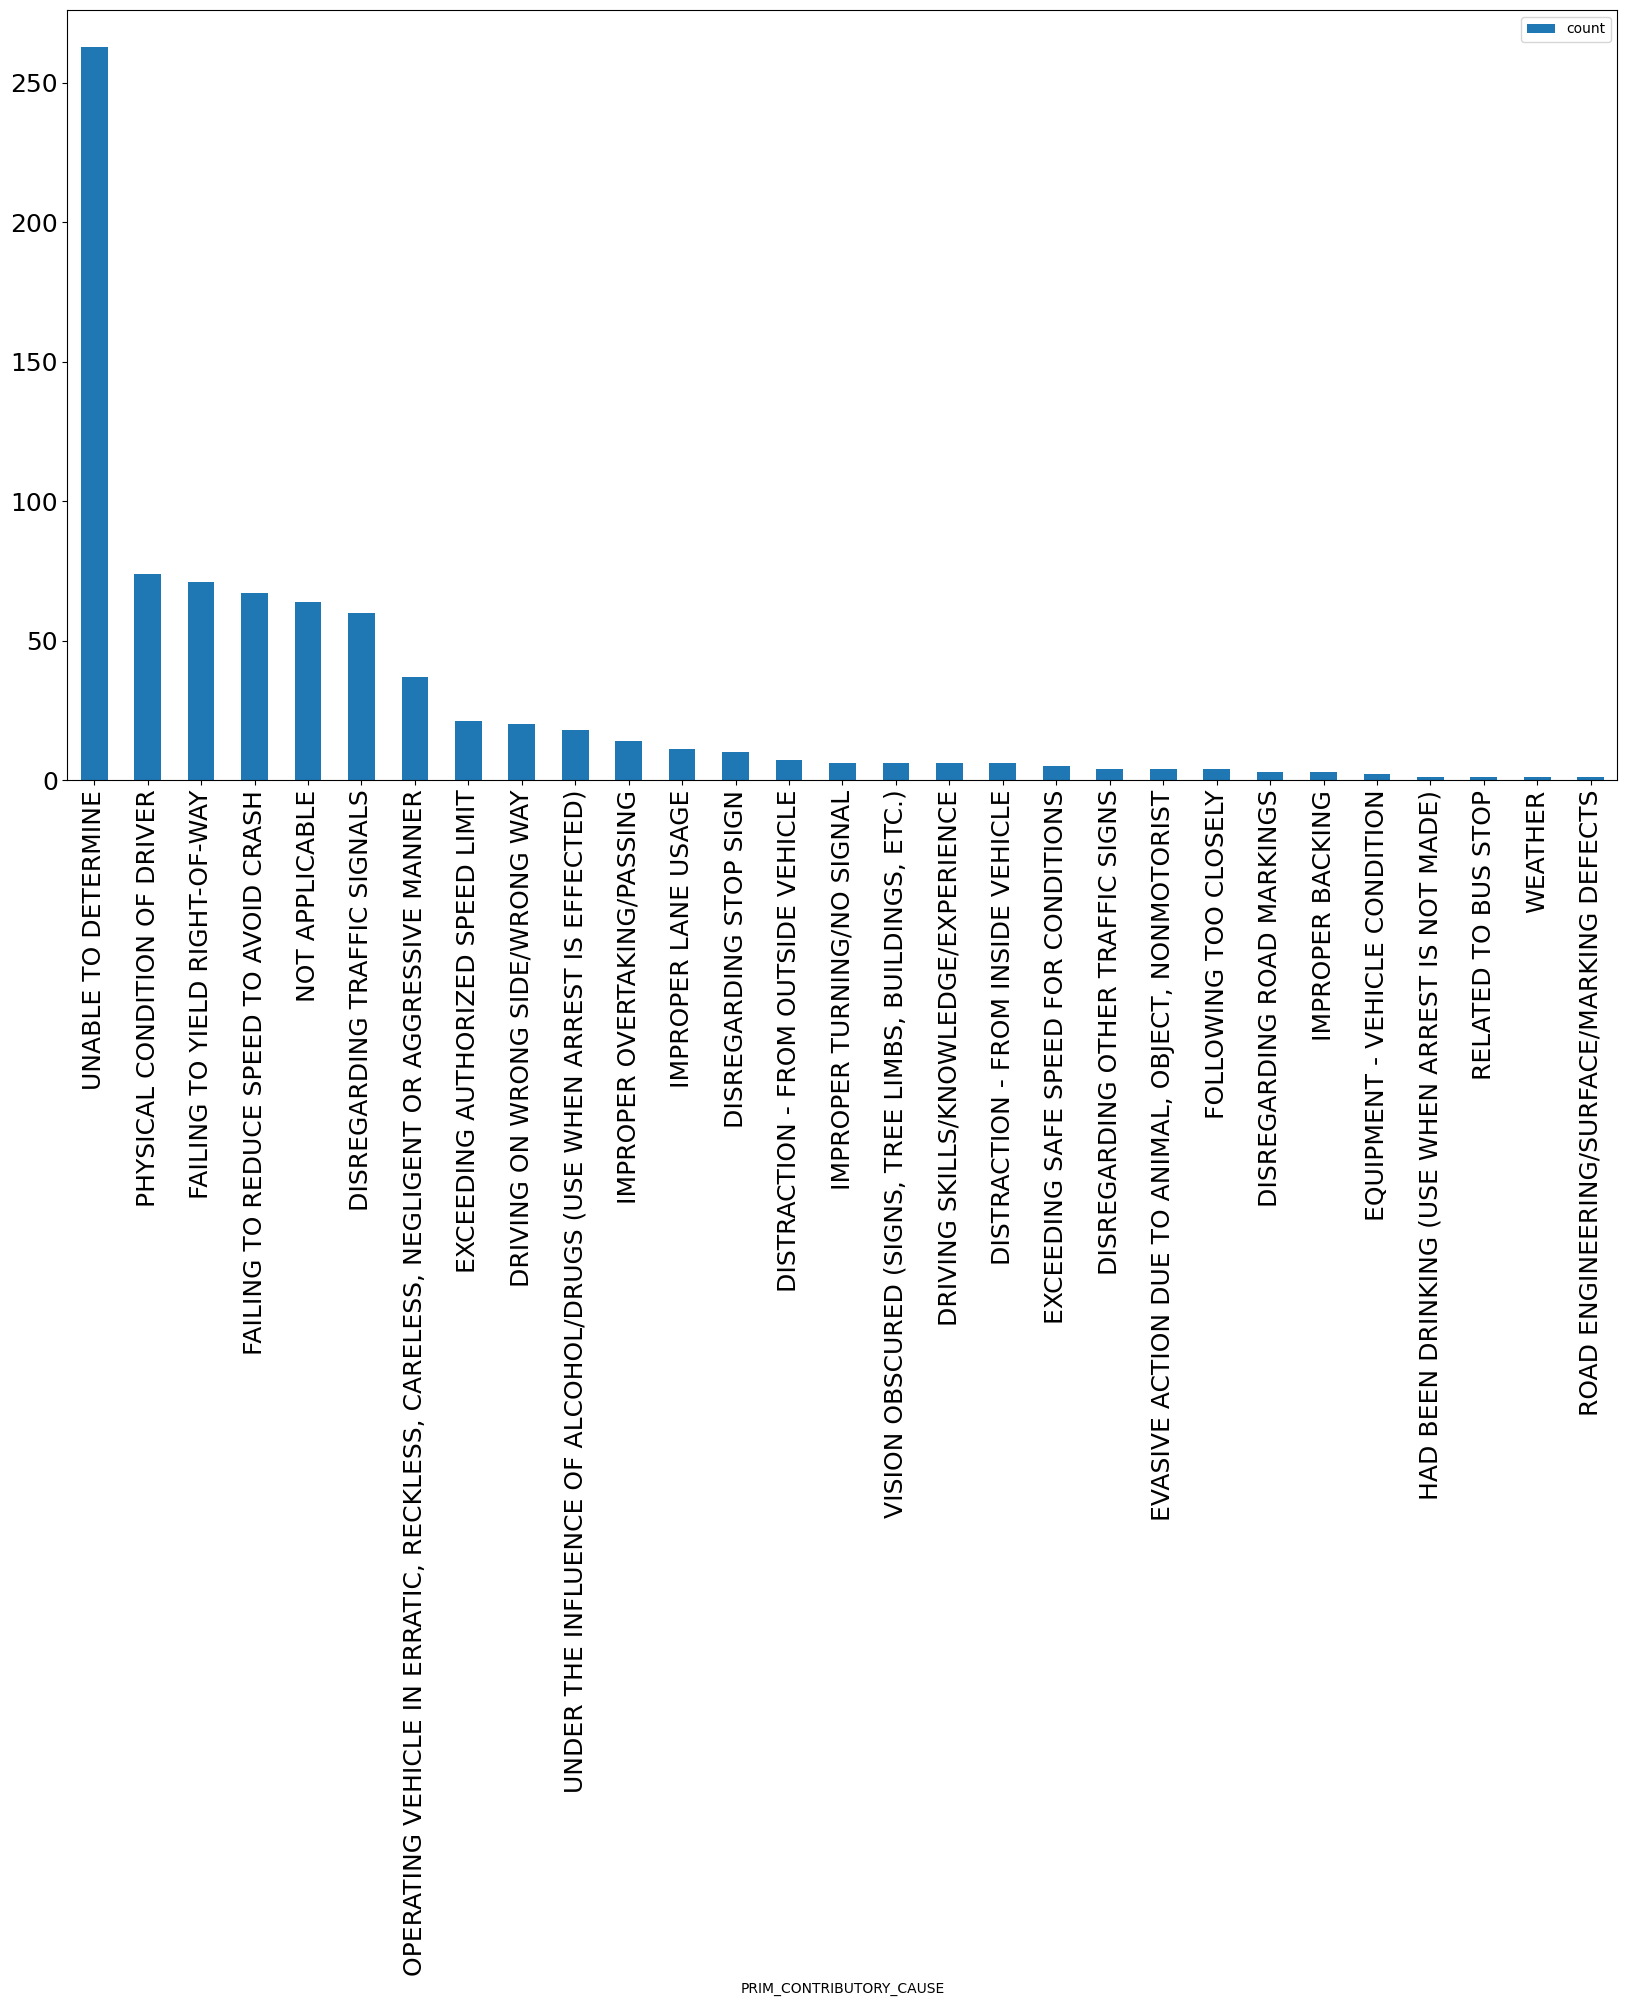

In [ ]:
#Question #2
#What first crash type causes the most injuries?
dfq2a = dfCrashes.groupby(dfCrashes['FIRST_CRASH_TYPE']).agg(F.sum(dfCrashes['INJURIES_TOTAL']))

dfq2aa = dfCrashes.filter(dfCrashes['INJURIES_TOTAL'] > 0).groupBy(dfCrashes['PRIM_CONTRIBUTORY_CAUSE']).count().orderBy(F.col('count').desc())

dfq2a.orderBy(dfq2a['sum(INJURIES_TOTAL)'].desc()).show(truncate=False)

#b. What first crash type causes the most fatalities?

dfq2b = dfCrashes.groupby(dfCrashes['FIRST_CRASH_TYPE']).agg(F.sum(dfCrashes['INJURIES_FATAL']))
dfq2b.orderBy(dfq2b['sum(INJURIES_FATAL)'].desc()).show(truncate=False)

dfq2ba = dfCrashes.filter(dfCrashes['INJURIES_FATAL'] > 0).groupBy(dfCrashes['PRIM_CONTRIBUTORY_CAUSE']).count().orderBy(F.col('count').desc())



#Graphs
if(dfq2a.count()<1000 and dfq2b.count() < 1000):
  pd = dfq2a.orderBy(dfq2a['sum(INJURIES_TOTAL)'].desc()).toPandas()
  pd.plot.bar(x='FIRST_CRASH_TYPE', y='sum(INJURIES_TOTAL)',figsize=(20, 10))
  pd = dfq2b.orderBy(dfq2b['sum(INJURIES_FATAL)'].desc()).toPandas()
  pd.plot.bar(x='FIRST_CRASH_TYPE', y='sum(INJURIES_FATAL)',figsize=(20, 10))
  pd = dfq2aa.toPandas()
  pd.plot.bar(x='PRIM_CONTRIBUTORY_CAUSE', y='count',figsize=(20, 10),fontsize = 18)
  pd = dfq2ba.toPandas()
  pd.plot.bar(x='PRIM_CONTRIBUTORY_CAUSE', y='count',figsize=(20, 10),fontsize = 18)

In [ ]:
#Question #3

#What is the rarest and most common first crash types?
dfq3 = dfCrashes.groupby(dfCrashes['FIRST_CRASH_TYPE']).count()
dfq3.orderBy(dfq3['count'].desc()).show(5,truncate = False)
dfq3 = dfCrashes.groupby(dfCrashes['FIRST_CRASH_TYPE']).count()
dfq3.orderBy(dfq3['count'].asc()).show(5,truncate = False)



+------------------------+------+
|FIRST_CRASH_TYPE        |count |
+------------------------+------+
|PARKED MOTOR VEHICLE    |168701|
|REAR END                |164211|
|SIDESWIPE SAME DIRECTION|110157|
|TURNING                 |102707|
|ANGLE                   |78359 |
+------------------------+------+
only showing top 5 rows

+------------------+-----+
|FIRST_CRASH_TYPE  |count|
+------------------+-----+
|TRAIN             |39   |
|OVERTURNED        |453  |
|ANIMAL            |511  |
|REAR TO REAR      |1332 |
|OTHER NONCOLLISION|2343 |
+------------------+-----+
only showing top 5 rows



In [ ]:
#Question #4
#What beats are most likely to have a hit and run?
dfq4 = dfCrashes.withColumn('HitRunSum',F.when(dfCrashes['HIT_AND_RUN_I']=='Y',1).otherwise(0)).groupby(dfCrashes['BEAT_OF_OCCURRENCE']).agg((F.sum('HitRunSum')/F.count('HitRunSum'))*100)
dfq4.orderBy(dfq4['((sum(HitRunSum) / count(HitRunSum)) * 100)'].desc()).show(truncate = False)


+------------------+-------------------------------------------+
|BEAT_OF_OCCURRENCE|((sum(HitRunSum) / count(HitRunSum)) * 100)|
+------------------+-------------------------------------------+
|1132              |49.38332511100148                          |
|1021              |46.64510913500404                          |
|1011              |45.764411027568926                         |
|1133              |45.45454545454545                          |
|1523              |45.14563106796117                          |
|1532              |45.06144742831133                          |
|421               |44.83554529717254                          |
|1115              |44.32358939496941                          |
|1524              |43.00804828973843                          |
|422               |43.00653594771242                          |
|1131              |42.847725774555045                         |
|631               |42.712842712842715                         |
|1531              |42.41

+----------------+-----------------+
|STREET_DIRECTION|       Percentage|
+----------------+-----------------+
|               E| 6.88269397021983|
|               N|23.81667877354973|
|               W|35.67875421554303|
|               S|33.62132063537659|
+----------------+-----------------+



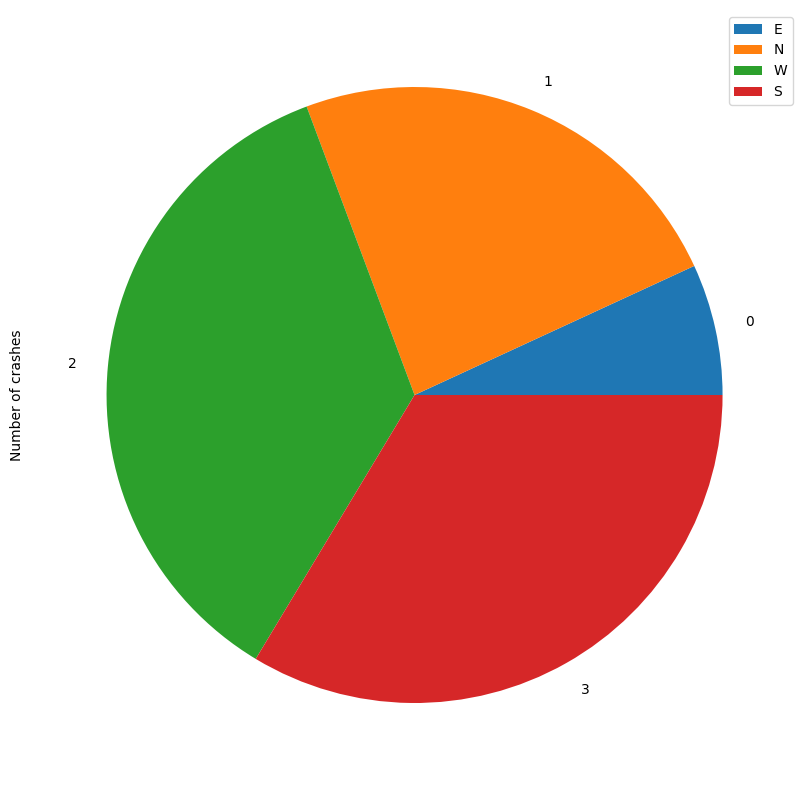

In [ ]:
#Question #5

#Do all street directions have equivalent probability of a crash?
total_traffic = dfCrashes.count()
dfq5 = dfCrashes.groupby('STREET_DIRECTION')\
                .agg((F.count('STREET_DIRECTION')/F.lit(total_traffic)*100)\
                .alias('Percentage')).na.drop()
dfq5.show()
#Graphs
if(dfq5.count()<1000):
  pd = dfq5.toPandas()
  pd.plot.pie(y='Percentage',figsize=(20, 10))
  pltra.legend(labels=pd['STREET_DIRECTION'].values)
  pltra.ylabel('Number of crashes')

In [ ]:
from pyspark.sql.functions import variance

In [ ]:
#Question #6
#Is there a relationship between the beat and the number of null values/unable to determine in its record?
dfCrashes.withColumn('NullCount',F.lit(0)).withColumn('NullCount',F.when(dfCrashes['CRASH_DATE_EST_I'].isNull(),F.col('NullCount')+1).when(dfCrashes['LANE_CNT'].isNull(),F.col('NullCount')+1).when(dfCrashes['CRASH_DATE_EST_I'].isNull(),F.col('NullCount')+1).when(dfCrashes['STATEMENTS_TAKEN_I'].isNull(),F.col('NullCount')+1).when(dfCrashes['DOORING_I'].isNull(),F.col('NullCount')+1).when(dfCrashes['LATITUDE'].isNull(),F.col('NullCount')+1).when(dfCrashes['LONGITUDE'].isNull(),F.col('NullCount')+1).when(dfCrashes['LOCATION'].isNull(),F.col('NullCount')+1)).groupBy(F.col('BEAT_OF_OCCURRENCE')).agg(F.sum('NullCount')).orderBy(F.col('sum(NullCount)').desc()).show()
#Same but ascending
dfCrashesNulls = dfCrashes.withColumn('NullCount',F.lit(0)).withColumn('NullCount',F.when(dfCrashes['CRASH_DATE_EST_I'].isNull(),F.col('NullCount')+1).when(dfCrashes['LANE_CNT'].isNull(),F.col('NullCount')+1).when(dfCrashes['CRASH_DATE_EST_I'].isNull(),F.col('NullCount')+1).when(dfCrashes['STATEMENTS_TAKEN_I'].isNull(),F.col('NullCount')+1).when(dfCrashes['DOORING_I'].isNull(),F.col('NullCount')+1).when(dfCrashes['LATITUDE'].isNull(),F.col('NullCount')+1).when(dfCrashes['LONGITUDE'].isNull(),F.col('NullCount')+1).when(dfCrashes['LOCATION'].isNull(),F.col('NullCount')+1)).groupBy(F.col('BEAT_OF_OCCURRENCE')).agg(F.sum('NullCount')).orderBy(F.col('sum(NullCount)').asc())
dfCrashesNulls.show()
#Finding the variance in null values across
dfCrashesNulls.select(variance('sum(NullCount)')).show()


+------------------+--------------+
|BEAT_OF_OCCURRENCE|sum(NullCount)|
+------------------+--------------+
|              1834|          8891|
|               114|          7409|
|               813|          7202|
|              1831|          6847|
|               815|          6819|
|               122|          6508|
|               833|          5926|
|               834|          5499|
|              2413|          5323|
|              2512|          5273|
|               331|          5204|
|              1232|          5135|
|              2533|          5035|
|               822|          4841|
|              1623|          4753|
|              1622|          4738|
|              1833|          4734|
|               632|          4693|
|               623|          4520|
|               823|          4519|
+------------------+--------------+
only showing top 20 rows

+------------------+--------------+
|BEAT_OF_OCCURRENCE|sum(NullCount)|
+------------------+--------------+
| 

In [ ]:
#Question #7
#a. What is the most common primary cause of crashes and on average how much damage is caused by it? b. What primary cause causes the most fatalities $501 - $1,500
dfCrashes.withColumn('DamageSum',F.when(dfCrashes['DAMAGE']=='OVER $1,500',2000).when(dfCrashes['DAMAGE']=='$500 OR LESS',250).when(dfCrashes['DAMAGE']=='$501 - $1,500',1000)).groupby(dfCrashes['PRIM_CONTRIBUTORY_CAUSE']).agg(F.sum('DamageSum')).orderBy(F.col('sum(DamageSum)').desc()).show(truncate = False)



+--------------------------------------------------------------------------------+--------------+
|PRIM_CONTRIBUTORY_CAUSE                                                         |sum(DamageSum)|
+--------------------------------------------------------------------------------+--------------+
|UNABLE TO DETERMINE                                                             |418442000     |
|FAILING TO YIELD RIGHT-OF-WAY                                                   |125636000     |
|FOLLOWING TOO CLOSELY                                                           |105612000     |
|NOT APPLICABLE                                                                  |54014000      |
|IMPROPER OVERTAKING/PASSING                                                     |51373250      |
|FAILING TO REDUCE SPEED TO AVOID CRASH                                          |50850000      |
|IMPROPER LANE USAGE                                                             |40415250      |
|IMPROPER BACKING   

+----------------+-----+
|STREET_NAME     |count|
+----------------+-----+
|WESTERN AVE     |19801|
|PULASKI RD      |17218|
|CICERO AVE      |16196|
|ASHLAND AVE     |15780|
|HALSTED ST      |14088|
|KEDZIE AVE      |12468|
|MICHIGAN AVE    |9245 |
|NORTH AVE       |8372 |
|STATE ST        |8359 |
|CLARK ST        |7777 |
|CALIFORNIA AVE  |7397 |
|STONY ISLAND AVE|7359 |
|GRAND AVE       |7275 |
|IRVING PARK RD  |7246 |
|DAMEN AVE       |7150 |
|CENTRAL AVE     |7137 |
|ARCHER AVE      |7090 |
|BELMONT AVE     |6821 |
|FULLERTON AVE   |6730 |
|87TH ST         |6709 |
+----------------+-----+
only showing top 20 rows

+---------------------------+-------------------+
|STREET_NAME                |sum(INJURIES_TOTAL)|
+---------------------------+-------------------+
|WESTERN AVE                |3835               |
|PULASKI RD                 |3778               |
|CICERO AVE                 |3381               |
|ASHLAND AVE                |3372               |
|HALSTED ST             

<Axes: xlabel='LONGITUDE', ylabel='LATITUDE'>

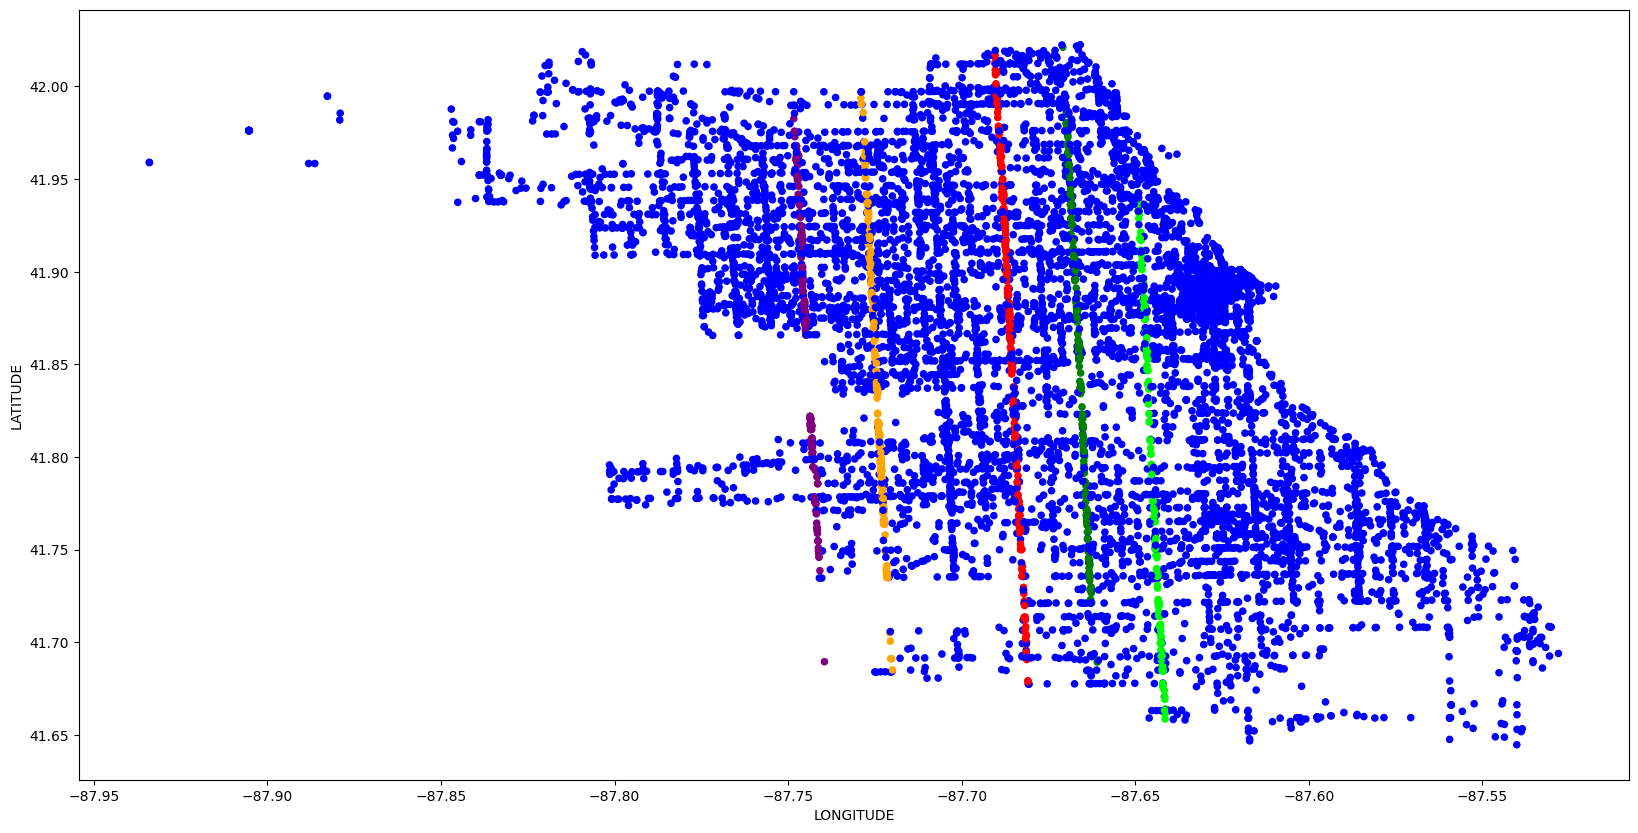

In [ ]:
#Question #8
#What are the most dangerous streets in:
#a. number of crashes
dfq8 = dfCrashes.groupby(dfCrashes['STREET_NAME']).count().orderBy(F.col('count').desc()).show(truncate = False)

#b. number of total injuries
dfq8 = dfCrashes.groupby(dfCrashes['STREET_NAME']).agg(F.sum(dfCrashes['INJURIES_TOTAL'])).orderBy(F.col('sum(INJURIES_TOTAL)').desc()).show(truncate = False)

#c. number of fatalities
dfq8 = dfCrashes.groupby(dfCrashes['STREET_NAME']).agg(F.sum(dfCrashes['INJURIES_FATAL'])).orderBy(F.col('sum(INJURIES_FATAL)').desc()).show(truncate = False)


#Top crash types per street
dfCrashes.filter((dfCrashes['STREET_NAME']=='WESTERN AVE')).groupBy(F.col('FIRST_CRASH_TYPE')).count().orderBy(F.col('count').desc()).show(truncate = False)
dfCrashes.filter((dfCrashes['STREET_NAME']=='PULASKI RD')).groupBy(F.col('FIRST_CRASH_TYPE')).count().orderBy(F.col('count').desc()).show(truncate = False)
dfCrashes.filter((dfCrashes['STREET_NAME']=='CICERO AVE')).groupBy(F.col('FIRST_CRASH_TYPE')).count().orderBy(F.col('count').desc()).show(truncate = False)
dfCrashes.filter((dfCrashes['STREET_NAME']=='ASHLAND AVE')).groupBy(F.col('FIRST_CRASH_TYPE')).count().orderBy(F.col('count').desc()).show(truncate = False)
dfCrashes.filter((dfCrashes['STREET_NAME']=='HALSTED ST')).groupBy(F.col('FIRST_CRASH_TYPE')).count().orderBy(F.col('count').desc()).show(truncate = False)


#Sample Plot of all crash locations
sampleDF = dfCrashes.withColumn('color',F.when(dfCrashes['STREET_NAME']=='HALSTED ST',F.lit('lime')).when(dfCrashes['STREET_NAME']=='ASHLAND AVE',F.lit('green')).when(dfCrashes['STREET_NAME']=='CICERO AVE',F.lit('purple')).when(dfCrashes['STREET_NAME']=='PULASKI RD',F.lit('orange')).when(dfCrashes['STREET_NAME']=='WESTERN AVE',F.lit('red')).otherwise(F.lit('blue'))).select(['LATITUDE','LONGITUDE','color']).filter(dfCrashes['LATITUDE'].isNotNull()).filter(dfCrashes['LATITUDE'] > 10).sample(10000/dfCrashes.count()).toPandas()
sampleDF.plot.scatter(x='LONGITUDE',y='LATITUDE',c='color',figsize=(20, 10))


+------------------+------+
|POSTED_SPEED_LIMIT|count |
+------------------+------+
|0                 |7295  |
|1                 |39    |
|2                 |26    |
|3                 |165   |
|4                 |2     |
|5                 |4424  |
|6                 |7     |
|7                 |5     |
|8                 |2     |
|9                 |95    |
|10                |16702 |
|11                |11    |
|12                |3     |
|14                |3     |
|15                |25599 |
|16                |1     |
|18                |2     |
|20                |30196 |
|22                |3     |
|23                |2     |
|24                |36    |
|25                |45599 |
|26                |6     |
|29                |3     |
|30                |532413|
|31                |2     |
|32                |18    |
|33                |13    |
|34                |14    |
|35                |48571 |
|36                |5     |
|38                |2     |
|39                |

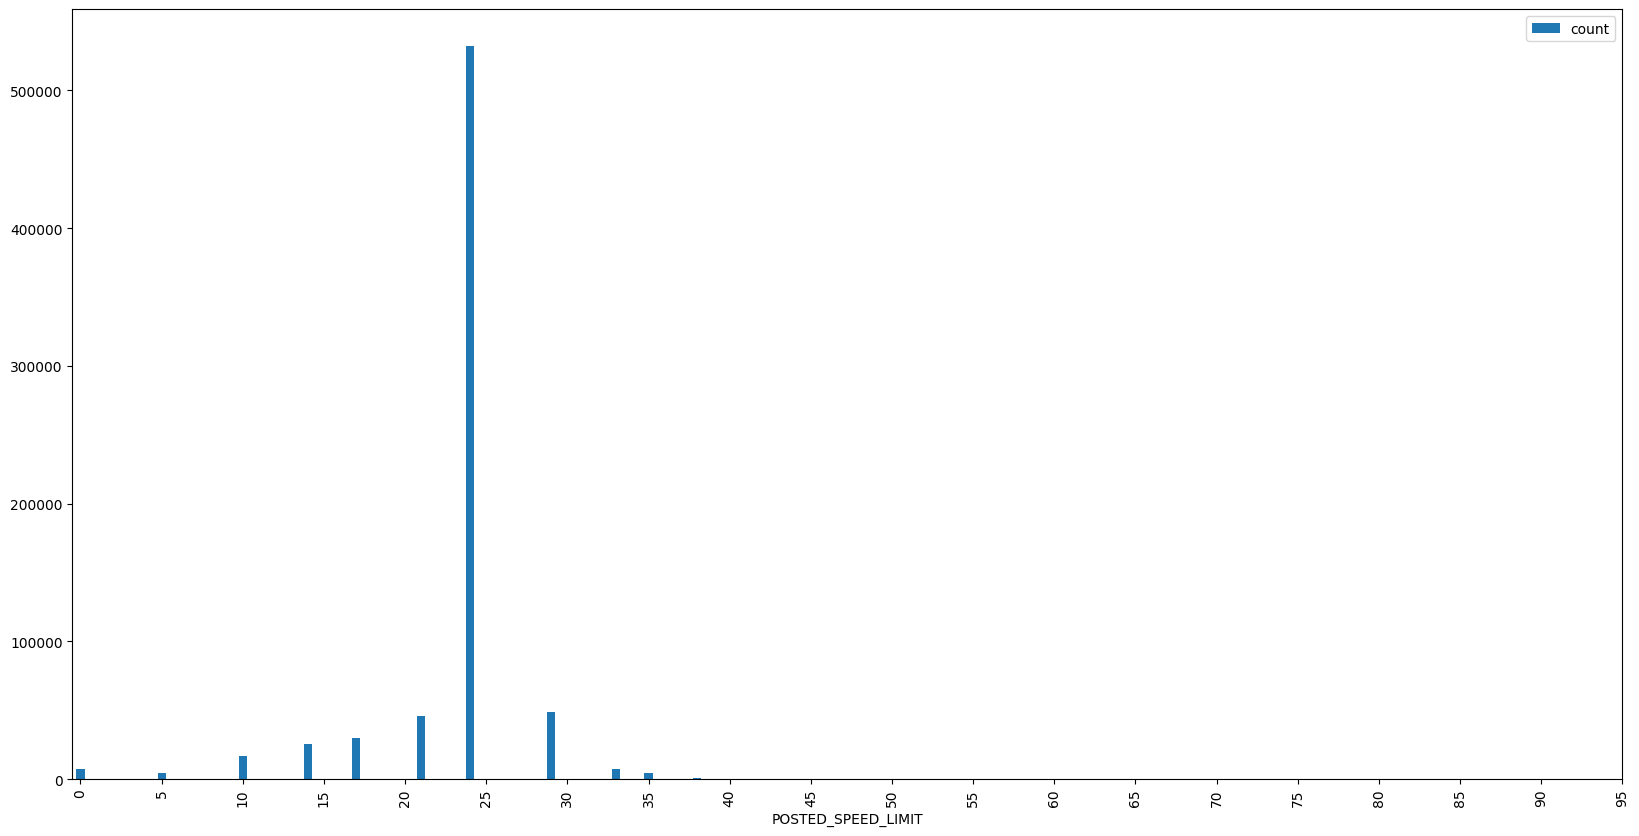

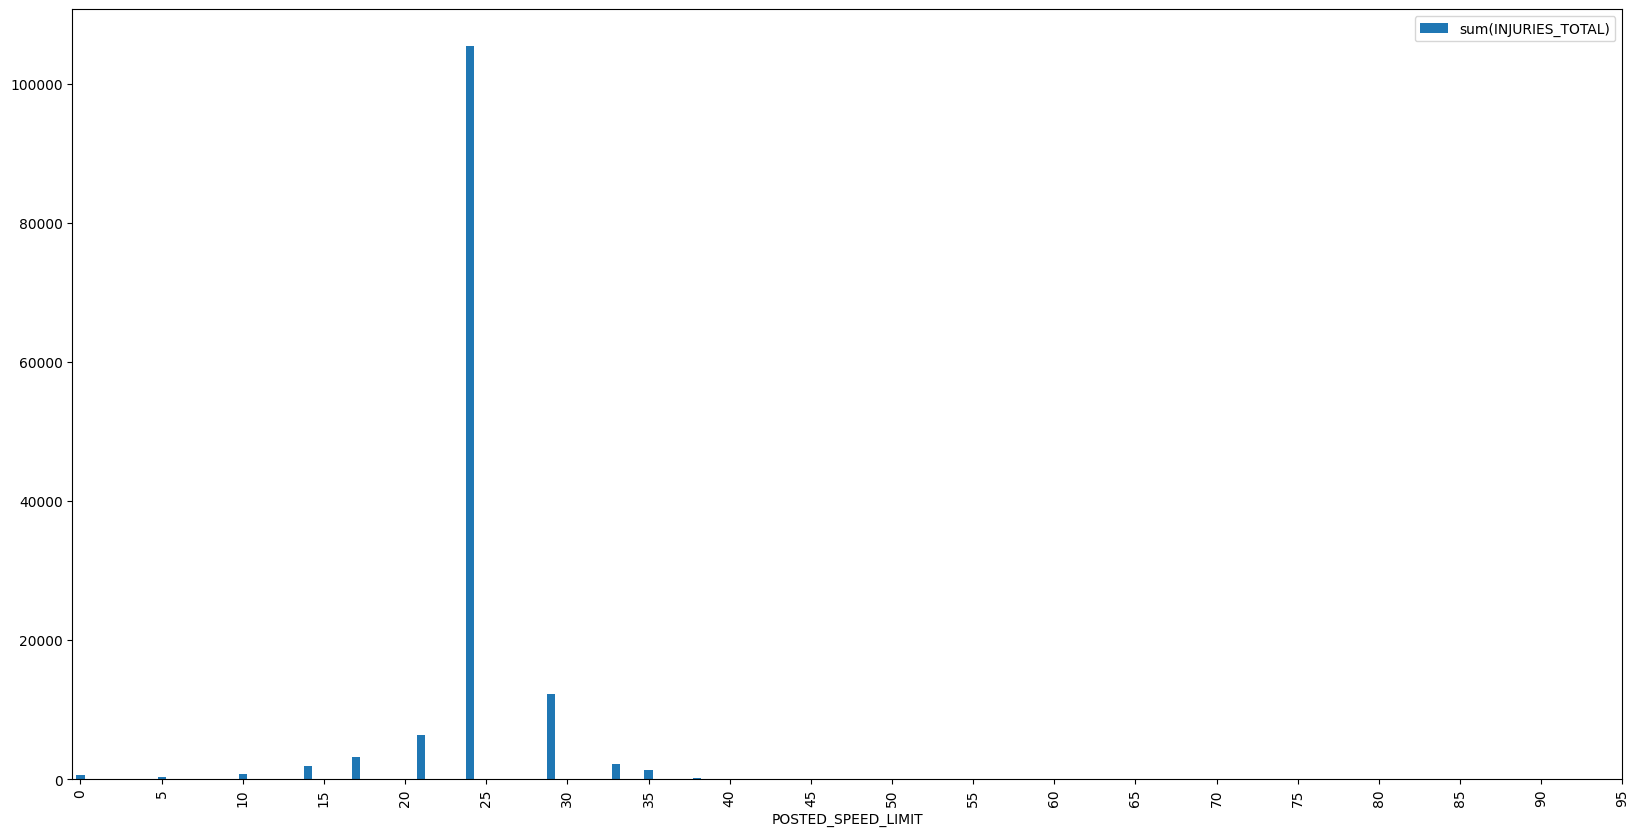

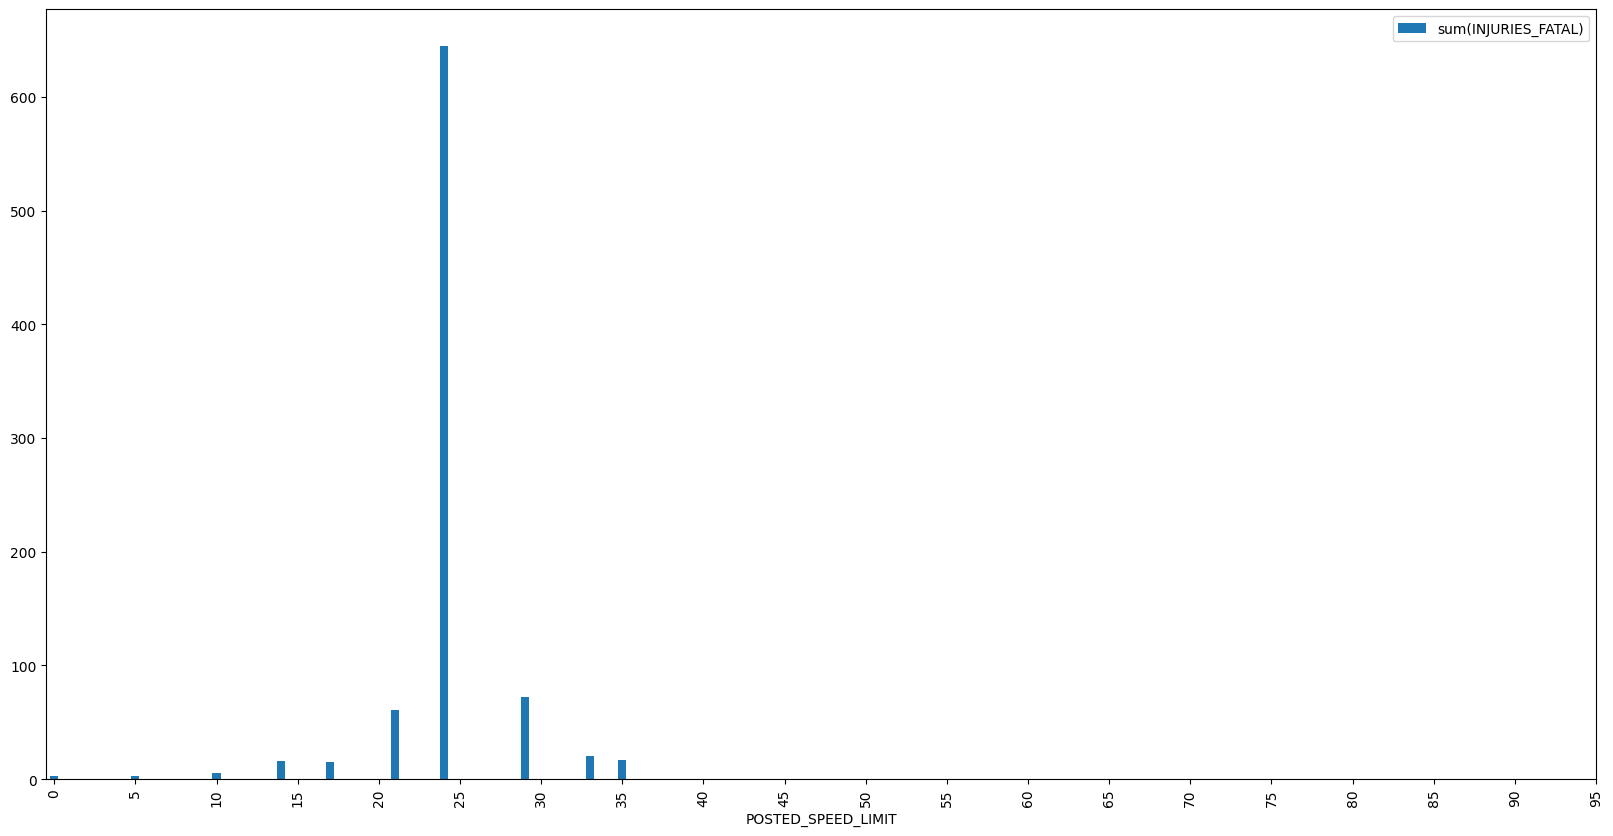

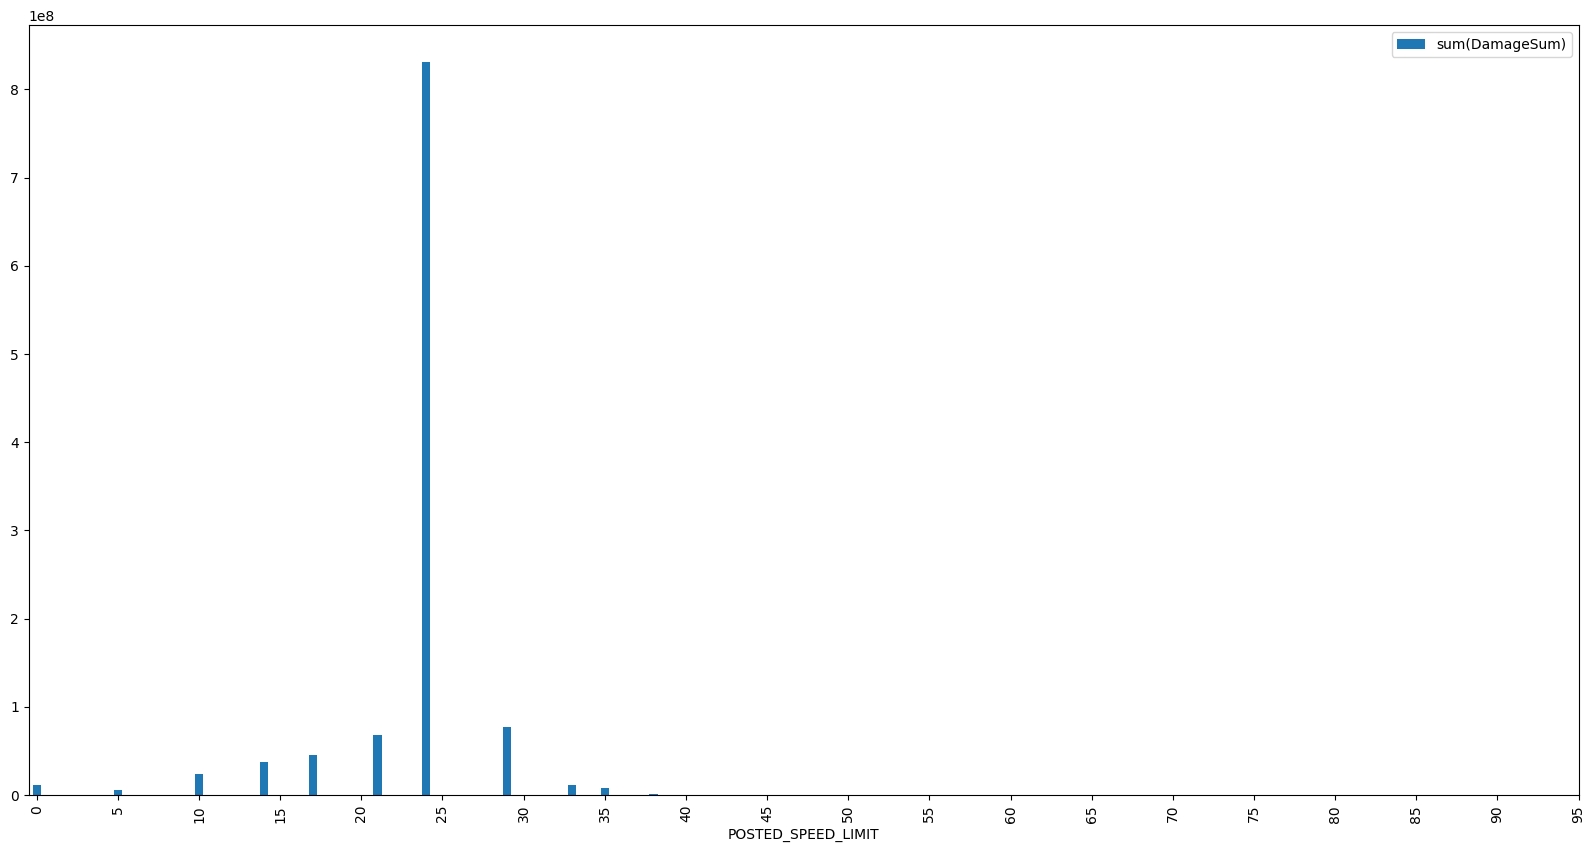

In [ ]:
#Question #9
#Do higher speed limits always result in worse outcomes? Is there an inflection point in speed limits past which theres a significant increase in crashes, injuries, etc.? a. More crashes b. More fatalities c. More injuries d. More damages
dfq9a = dfCrashes.groupby(dfCrashes['POSTED_SPEED_LIMIT']).count().orderBy(F.col('POSTED_SPEED_LIMIT').asc())#.show(truncate = False)
dfq9a.show(50, truncate = False)

# injuries, etc.?
dfq9b = dfCrashes.groupby(dfCrashes['POSTED_SPEED_LIMIT']).agg((F.sum(dfCrashes['INJURIES_TOTAL']))).orderBy(F.col('POSTED_SPEED_LIMIT').asc())
dfq9b.show(truncate = False)

# More fatalities
dfq9c = dfCrashes.groupby(dfCrashes['POSTED_SPEED_LIMIT']).agg((F.sum(dfCrashes['INJURIES_FATAL']))).orderBy(F.col('POSTED_SPEED_LIMIT').asc())
dfq9c.show(truncate = False)

#More Damages
dfq9d = dfCrashes.withColumn('DamageSum',F.when(dfCrashes['DAMAGE']=='OVER $1,500',2000).when(dfCrashes['DAMAGE']=='$500 OR LESS',500).when(dfCrashes['DAMAGE']=='$501 - $1,500',1000)).groupby(dfCrashes['POSTED_SPEED_LIMIT']).agg((F.sum('DamageSum'))).orderBy(F.col('POSTED_SPEED_LIMIT').asc())
dfq9d.show(truncate = False)


xticks = range(0,100,5)
#Graphs
if(dfq9a.count()<1000 and dfq9b.count() < 1000 and dfq9c.count() < 1000 and dfq9d.count() < 1000):
  pd = dfq9a.toPandas()
  pd.plot.bar(x='POSTED_SPEED_LIMIT', y='count',figsize=(20, 10),xticks =xticks)
  pd = dfq9b.toPandas()
  pd.plot.bar(x='POSTED_SPEED_LIMIT', y='sum(INJURIES_TOTAL)',figsize=(20, 10), xticks= xticks)
  pd = dfq9c.toPandas()
  pd.plot.bar(x='POSTED_SPEED_LIMIT', y='sum(INJURIES_FATAL)',figsize=(20, 10), xticks = xticks)
  pd = dfq9d.toPandas()
  pd.plot.bar(x='POSTED_SPEED_LIMIT', y='sum(DamageSum)',figsize=(20, 10), xticks = xticks)




<Axes: xlabel='LONGITUDE', ylabel='LATITUDE'>

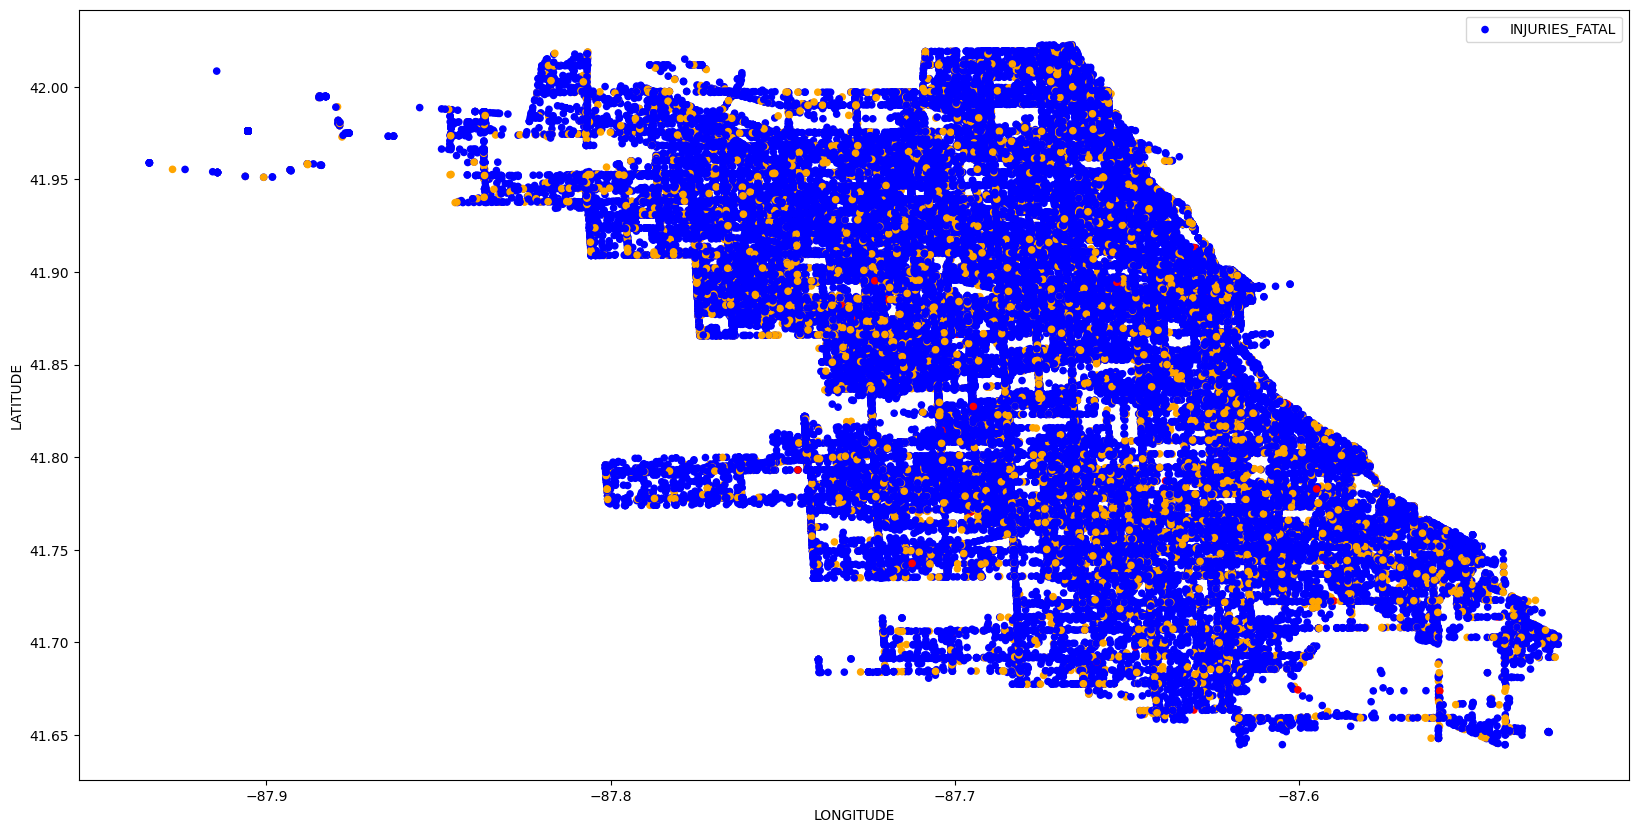

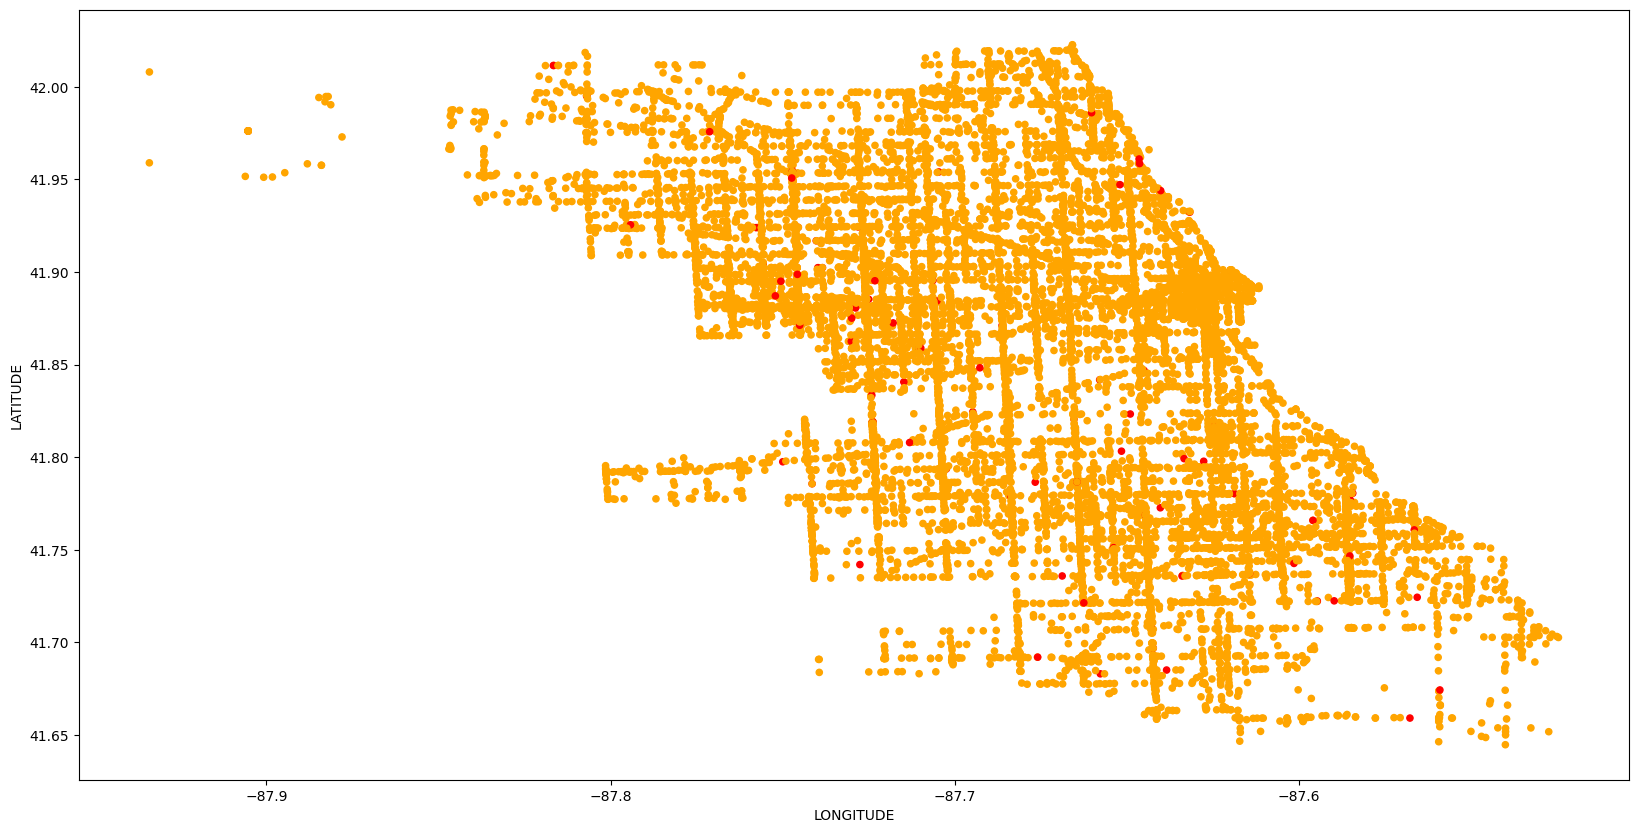

In [ ]:
#Question #10
#Analyze the location data of crashes with Injuries vs Fatal

sampleDF = dfCrashes.filter((dfCrashes['LONGITUDE'] != 0) & (dfCrashes['LATITUDE'] != 0)).withColumn('color', F.when(dfCrashes['INJURIES_FATAL'] > 0,F.lit('red')).when(dfCrashes['INJURIES_TOTAL'] > 0,F.lit('orange')).otherwise(F.lit('blue'))).sample(100000/dfCrashes.count())#~10,000 rows


sampleDF.toPandas().plot.scatter(x='LONGITUDE',y='LATITUDE',c='color',figsize=(20, 10)).legend(['INJURIES_FATAL','INJURIES_TOTAL'])

#Just injuries vs fatal

sampleDF3 = dfCrashes.filter((dfCrashes['LONGITUDE'] != 0) & (dfCrashes['LATITUDE'] != 0)).filter((dfCrashes['INJURIES_TOTAL'] > 0)  | (dfCrashes['INJURIES_FATAL'] > 0)).withColumn('color', F.when(dfCrashes['INJURIES_FATAL'] > 0,F.lit('red')).when(dfCrashes['INJURIES_TOTAL'] > 0,F.lit('orange')).otherwise(F.lit('blue'))).sample(100000/dfCrashes.count())
sampleDF3.toPandas().plot.scatter(x='LONGITUDE',y='LATITUDE',c='color',figsize=(20, 10))

<Axes: xlabel='LONGITUDE', ylabel='LATITUDE'>

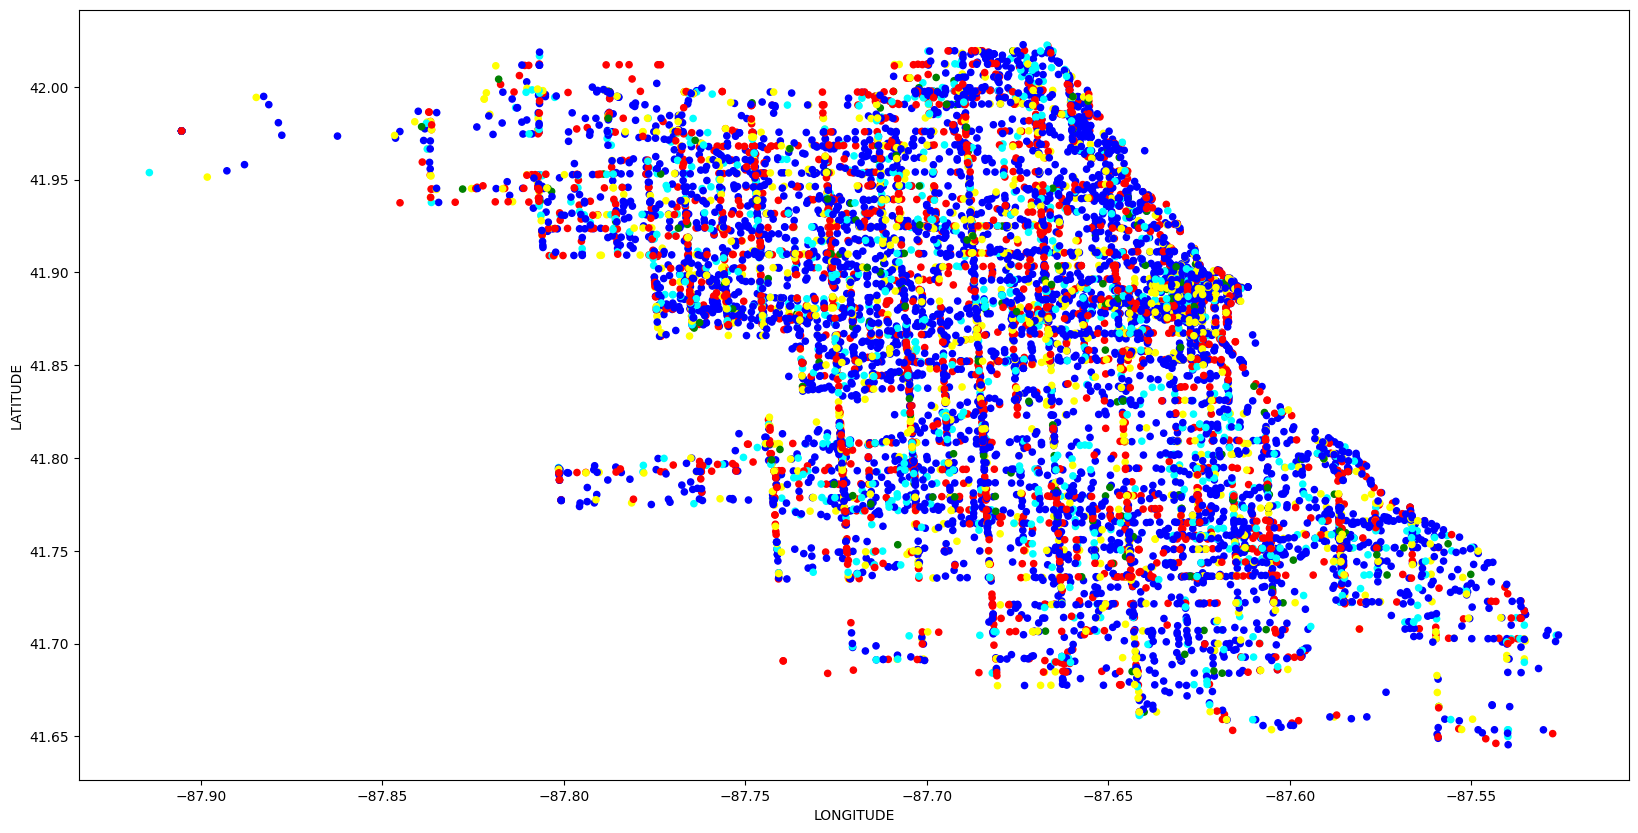

In [ ]:

#By Crash Type
sampleDF2 = dfCrashes.filter((dfCrashes['LONGITUDE'] != 0) & (dfCrashes['LATITUDE'] != 0)).withColumn('color', F.when(dfCrashes['FIRST_CRASH_TYPE'] == 'REAR END',F.lit('red')).when(dfCrashes['FIRST_CRASH_TYPE'] == 'ANGLE',F.lit('cyan')).when(dfCrashes['FIRST_CRASH_TYPE'] == 'TURNING',F.lit('yellow')).when(dfCrashes['FIRST_CRASH_TYPE'] == 'PEDESTRIAN',F.lit('green')).when(dfCrashes['FIRST_CRASH_TYPE'] == 'TRAIN',F.lit('black')).otherwise(F.lit('blue'))).sample(10000/dfCrashes.count())
sampleDF2.toPandas().plot.scatter(x='LONGITUDE',y='LATITUDE',c='color',figsize=(20, 10))
